In [1]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
from google.protobuf.json_format import MessageToDict
import collections
import numpy as np
import glob
import seaborn as sns
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import pprint
from IPython.display import display
from datetime import date
# rcParams.keys()

In [ ]:
os.getcwd()

In [2]:
DATA_PATH = '../experiment_et_data/'
PROCESSED_DATA_PATH = '../ProcessedData'
PLOT_PATH = f'./PLOTS-{date.today().strftime("%b-%d-%Y")}/data_quality'

os.makedirs(os.path.dirname(PROCESSED_DATA_PATH), exist_ok=True)
os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)

sns.set(context = "talk", style="white", palette="deep", font_scale=1,\
        rc={'figure.figsize':(11.7,8.27), 'font.size':15, 'font.sans-serif':'DejaVu Sans'})
# COLORS = ['red']

## Reading all protobuf files and combining in single csv

In [ ]:
protobuf_obj = ProtobufTypes_pb2.EyetrackingDataSet()
files = glob.glob(f'{DATA_PATH}/subject2*.etd')
samples_df = pd.DataFrame()
shelf_df = pd.DataFrame()
for fi in files:
    try:
        print(fi)
        with open(fi, "rb") as f:
            protobuf_obj.ParseFromString(f.read())
        dict_obj = MessageToDict(protobuf_obj)
        for nT, trial in enumerate(dict_obj['trials']):
            tmpdf = pd.io.json.json_normalize(data=trial['samples'])
#             if fi.endswith('_2.etd'):                
            tmpdf['trialID'] = trial['metaData']['trialID'] if 'trialID' in trial['metaData'] else np.NaN  
            tmpdf['subjectID'] = dict_obj['subjectID']
            tmpdf['trialNum'] = nT
            tmpdf['subjectfileName'] = fi

            samples_df = pd.concat([samples_df, tmpdf], ignore_index=True, sort=False)             
            
            tmpdf = pd.io.json.json_normalize(data=trial['metaData']['initialConfiguration']['items'])
            tmpdf['trialID'] = trial['metaData']['trialID'] if 'trialID' in trial['metaData'] else np.NaN  
            tmpdf['subjectID'] = dict_obj['subjectID']
            tmpdf['subjectfileName'] = fi
            tmpdf['trialNum'] = nT
            shelf_df = pd.concat([shelf_df, tmpdf], ignore_index=True, sort=False) 
            
    except FileNotFoundError:
        print("{} not found, moving on!".format(fi))

samples_df.to_csv(f'{PROCESSED_DATA_PATH}/00_ET_samples_master.csv', index=False)
shelf_df.to_csv(f'{PROCESSED_DATA_PATH}/00_ET_shelfData_master.csv', index=False)

In [4]:
display(samples_df.shape)
display(samples_df.columns)

(11020553, 60)

Index(['timestamp', 'leftEye.position.x', 'leftEye.position.y',
       'leftEye.position.z', 'leftEye.direction.x', 'leftEye.direction.y',
       'leftEye.direction.z', 'leftEye.raycastHitObject',
       'leftEye.raycastHitLocation.x', 'leftEye.raycastHitLocation.y',
       'leftEye.raycastHitLocation.z', 'rightEye.position.x',
       'rightEye.position.y', 'rightEye.position.z', 'rightEye.direction.x',
       'rightEye.direction.y', 'rightEye.direction.z',
       'rightEye.raycastHitObject', 'rightEye.raycastHitLocation.x',
       'rightEye.raycastHitLocation.y', 'rightEye.raycastHitLocation.z',
       'combinedEye.position.x', 'combinedEye.position.y',
       'combinedEye.position.z', 'combinedEye.direction.x',
       'combinedEye.direction.y', 'combinedEye.direction.z',
       'combinedEye.raycastHitObject', 'combinedEye.raycastHitLocation.x',
       'combinedEye.raycastHitLocation.y', 'combinedEye.raycastHitLocation.z',
       'nosePointer.position.x', 'nosePointer.position.y',
   

In [ ]:
# del samples_df
del shelf_df

In [32]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/00_ET_samples_master.csv', index_col=False, )

### Checking data missing values and changing column names to remove '_'

In [33]:
# display(samples_df.info())
display(samples_df.isna().mean())
samples_df.columns = [col.replace('.','_') for col in samples_df.columns]

timestamp                           0.000000e+00
leftEye.position.x                  2.300039e-02
leftEye.position.y                  2.300402e-02
leftEye.position.z                  2.300039e-02
leftEye.direction.x                 2.305783e-02
leftEye.direction.y                 2.304921e-02
leftEye.direction.z                 0.000000e+00
leftEye.raycastHitObject            2.302480e-02
leftEye.raycastHitLocation.x        2.302480e-02
leftEye.raycastHitLocation.y        2.900671e-02
leftEye.raycastHitLocation.z        2.302480e-02
rightEye.position.x                 1.982940e-02
rightEye.position.y                 1.983185e-02
rightEye.position.z                 1.982940e-02
rightEye.direction.x                1.989946e-02
rightEye.direction.y                1.988049e-02
rightEye.direction.z                0.000000e+00
rightEye.raycastHitObject           1.986751e-02
rightEye.raycastHitLocation.x       1.986751e-02
rightEye.raycastHitLocation.y       2.656573e-02
rightEye.raycastHitL

In [34]:
samples_df.loc[samples_df['subjectfileName'].str.endswith('_2.etd', na=False), 'trialNum'] = \
samples_df.loc[samples_df['subjectfileName'].str.endswith('_2.etd', na=False), 'trialNum']  + 12

In [ ]:
samples_df.trialID.unique()

## Calculate horizontal and vertical angles for both eyes and head

In [35]:
samples_df['left_eye_theta_h'] = np.arctan2(samples_df['leftEye_direction_x'], samples_df['leftEye_direction_z'])
samples_df['left_eye_theta_v'] = np.arctan2(samples_df['leftEye_direction_y'], samples_df['leftEye_direction_z'])
samples_df['right_eye_theta_h'] = np.arctan2(samples_df['rightEye_direction_x'], samples_df['rightEye_direction_z'])
samples_df['right_eye_theta_v'] = np.arctan2(samples_df['rightEye_direction_y'], samples_df['rightEye_direction_z'])
samples_df['combined_eye_theta_h'] = np.arctan2(samples_df['combinedEye_direction_x'], samples_df['combinedEye_direction_z'])
samples_df['combined_eye_theta_v'] = np.arctan2(samples_df['combinedEye_direction_y'], samples_df['combinedEye_direction_z'])

In [36]:
samples_df['left_eye_vel_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .left_eye_theta_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['left_eye_vel_h'] = samples_df['left_eye_vel_h']*180/np.pi

samples_df['left_eye_vel_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .left_eye_theta_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['left_eye_vel_v'] = samples_df['left_eye_vel_v']*180/np.pi

samples_df['right_eye_vel_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .right_eye_theta_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['right_eye_vel_h'] = samples_df['right_eye_vel_h']*180/np.pi

samples_df['right_eye_vel_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .right_eye_theta_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['right_eye_vel_v'] = samples_df['right_eye_vel_v']*180/np.pi

samples_df['combined_eye_vel_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .combined_eye_theta_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['combined_eye_vel_h'] = samples_df['combined_eye_vel_h']*180/np.pi

samples_df['combined_eye_vel_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .combined_eye_theta_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['combined_eye_vel_v'] = samples_df['combined_eye_vel_v']*180/np.pi


In [37]:
samples_df['left_eye_acc_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .left_eye_vel_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['left_eye_acc_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .left_eye_vel_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['right_eye_acc_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .right_eye_vel_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['right_eye_acc_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .right_eye_vel_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['combined_eye_acc_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .combined_eye_vel_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['combined_eye_acc_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .combined_eye_vel_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))

c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [38]:
samples_df['head_theta_h'] = np.arctan2(samples_df['nosePointer_direction_x'], samples_df['nosePointer_direction_z'])
samples_df['head_theta_v'] = np.arctan2(samples_df['nosePointer_direction_y'], samples_df['nosePointer_direction_z'])


samples_df['head_vel_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .head_theta_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['head_vel_h'] = samples_df['head_vel_h']*180/np.pi
samples_df['head_vel_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .head_theta_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['head_vel_v'] = samples_df['head_vel_v']*180/np.pi

samples_df['head_acc_h'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .head_vel_h
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))
samples_df['head_acc_v'] = (samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .head_vel_v
                                .apply(lambda x: x.diff()))/(samples_df
                                .groupby(['subjectID','subjectfileName','trialNum'])
                                .timestamp
                                .apply(lambda x: x.diff()))

In [39]:
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/01_ET_samples_withVelocity.csv', index=False)


In [86]:
samples_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/01_ET_samples_withVelocity.csv')

c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [90]:
samples_df['angular_vel'] =np.sqrt(samples_df.combined_eye_vel_h**2 + samples_df.combined_eye_vel_v**2)
samples_df['head_angular_vel'] =np.sqrt(samples_df.head_vel_h**2 + samples_df.head_vel_v**2)

### Head Eye velocity distributions

In [91]:
samples_df.combined_eye_vel_h = samples_df.combined_eye_vel_h.replace([np.inf, -np.inf], np.nan)
samples_df.head_vel_h = samples_df.head_vel_h.replace([np.inf, -np.inf], np.nan)
samples_df.combined_eye_vel_v = samples_df.combined_eye_vel_v.replace([np.inf, -np.inf], np.nan)
samples_df.head_vel_v = samples_df.head_vel_v.replace([np.inf, -np.inf], np.nan)

samples_df.combined_eye_acc_h = samples_df.combined_eye_acc_h.replace([np.inf, -np.inf], np.nan)
samples_df.head_acc_h = samples_df.head_acc_h.replace([np.inf, -np.inf], np.nan)
samples_df.combined_eye_acc_v = samples_df.combined_eye_acc_v.replace([np.inf, -np.inf], np.nan)


samples_df.angular_vel = samples_df.angular_vel.replace([np.inf, -np.inf], np.nan)
samples_df.head_angular_vel = samples_df.head_angular_vel.replace([np.inf, -np.inf], np.nan)

samples_df = samples_df.dropna(subset=['combined_eye_vel_h','head_vel_h',\
                                       'combined_eye_acc_h', 'head_acc_h',\
                                       'combined_eye_vel_v', 'head_vel_v',\
                                       'combined_eye_acc_v', 'head_acc_v',\
                                      'angular_vel', 'head_angular_vel'])

display(samples_df.combined_eye_vel_h.describe())
display(samples_df.combined_eye_vel_v.describe())
display(samples_df.combined_eye_acc_h.describe())
display(samples_df.combined_eye_acc_v.describe())
display(samples_df.head_vel_h.describe())
display(samples_df.head_vel_v.describe())
display(samples_df.head_acc_h.describe())
display(samples_df.head_acc_v.describe())
display(samples_df.angular_vel.describe())
display(samples_df.head_angular_vel.describe())

count    1.059491e+07
mean    -2.679670e-02
std      1.483081e+02
min     -6.858626e+03
25%     -3.386915e+01
50%      0.000000e+00
75%      3.428250e+01
max      6.237354e+03
Name: combined_eye_vel_h, dtype: float64

count    1.059491e+07
mean    -4.553317e-01
std      1.871293e+02
min     -1.001369e+04
25%     -2.216850e+01
50%      0.000000e+00
75%      2.025748e+01
max      9.190680e+03
Name: combined_eye_vel_v, dtype: float64

count    1.059491e+07
mean    -1.409692e+01
std      1.615792e+04
min     -1.221330e+06
25%     -3.915370e+03
50%      0.000000e+00
75%      3.952878e+03
max      9.288227e+05
Name: combined_eye_acc_h, dtype: float64

count    1.059491e+07
mean    -4.750779e+01
std      2.518064e+04
min     -1.812949e+06
25%     -2.655033e+03
50%      0.000000e+00
75%      2.656240e+03
max      1.344871e+06
Name: combined_eye_acc_v, dtype: float64

count    1.059491e+07
mean     6.151130e-01
std      5.017388e+01
min     -3.258789e+04
25%     -1.463896e+01
50%     -1.523137e-01
75%      1.474641e+01
max      3.390257e+04
Name: head_vel_h, dtype: float64

count    1.059491e+07
mean    -6.474527e-01
std      1.495462e+02
min     -3.619515e+04
25%     -1.225569e+01
50%     -6.611530e-01
75%      1.059889e+01
max      4.009588e+04
Name: head_vel_v, dtype: float64

count    1.059491e+07
mean     1.915036e-02
std      4.133759e+03
min     -2.961550e+06
25%     -1.558244e+02
50%     -3.272796e-01
75%      1.545969e+02
max      3.195823e+06
Name: head_acc_h, dtype: float64

count    1.059491e+07
mean     2.713422e+00
std      1.863923e+04
min     -5.986513e+06
25%     -1.750532e+02
50%     -3.042738e+00
75%      1.701205e+02
max      5.947192e+06
Name: head_acc_v, dtype: float64

count    1.059491e+07
mean     1.153485e+02
std      2.090636e+02
min      0.000000e+00
25%      2.007984e+01
50%      5.213873e+01
75%      1.294802e+02
max      1.064618e+04
Name: angular_vel, dtype: float64

count    1.059491e+07
mean     3.773160e+01
std      1.531620e+02
min      0.000000e+00
25%      1.180894e+01
50%      2.516000e+01
75%      4.737165e+01
max      4.009589e+04
Name: head_angular_vel, dtype: float64

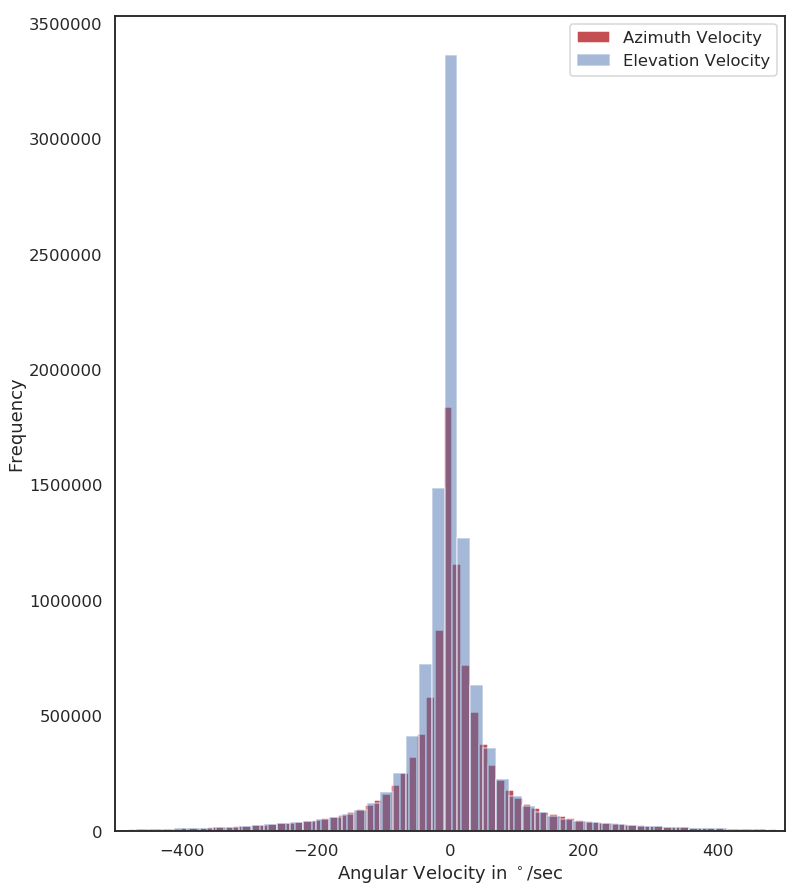

In [94]:
_, ax = plt.subplots(1,1,figsize=(12,15), sharey=True)

(samples_df
.combined_eye_vel_h
.plot
.hist(bins=1000, color='r', ax=ax, label='Azimuth Velocity', legend=True,)
)
(samples_df
.combined_eye_vel_v
.plot
.hist(bins=1000, color='b', ax=ax, label='Elevation Velocity', legend=True, alpha=0.5)
)
ax.set(xlim=(-500, 500), xlabel = 'Angular Velocity in $^\circ$/sec')
plt.savefig(f'{PLOT_PATH}/Angular_velocity_hist.png', transparent=True, bbox_inches='tight', quality=90)

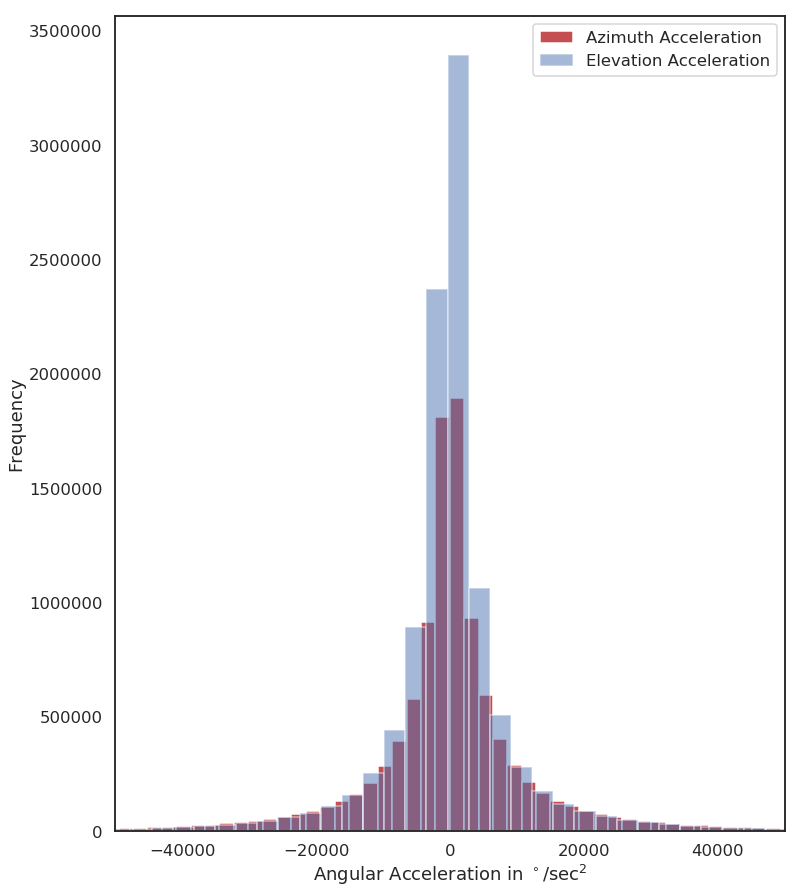

In [101]:
_, ax = plt.subplots(1,1,figsize=(12,15), sharey=True)

(samples_df
.combined_eye_acc_h
.plot
.hist(bins=1000,color='r', ax=ax, label='Azimuth Acceleration', legend=True, )
)
(samples_df
.combined_eye_acc_v
.plot
.hist(bins=1000, color='b', ax=ax, label='Elevation Acceleration', legend=True, alpha=0.5,)
)
ax.set(xlim=(-50000, 50000), xlabel = 'Angular Acceleration in $^\circ$/sec$^2$')
plt.savefig(f'{PLOT_PATH}/Angular_acc_hist.png', transparent=True, bbox_inches='tight', quality=90)

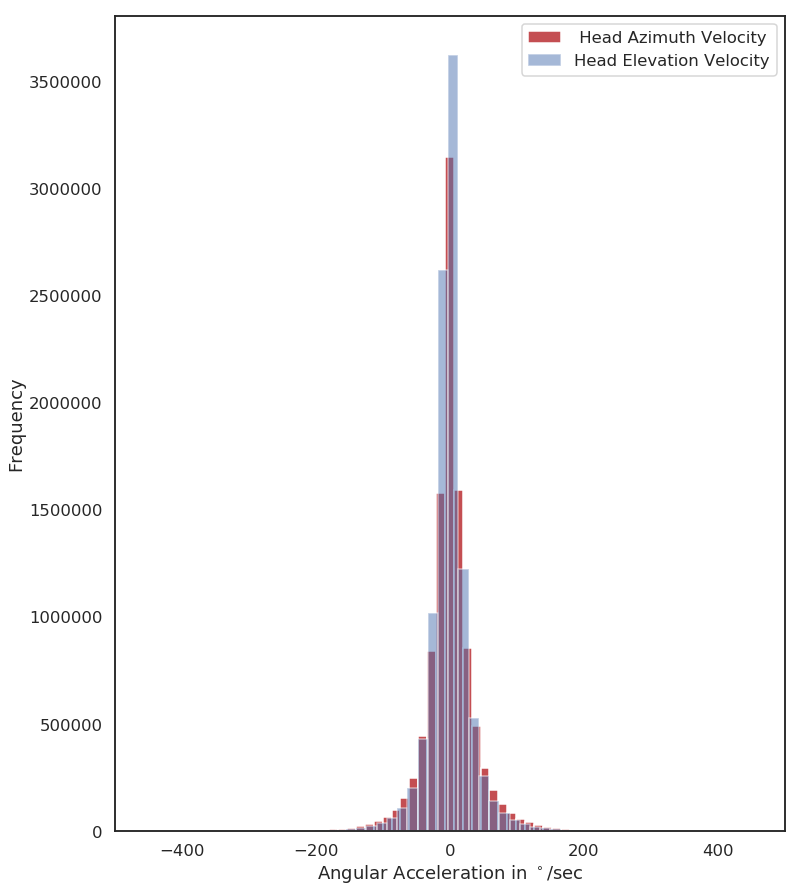

In [105]:
_, ax = plt.subplots(1,1,figsize=(12,15), sharey=True)

(samples_df
.head_vel_h
.plot
.hist(bins=5000,color='r', ax=ax, label=' Head Azimuth Velocity', legend=True)
)
(samples_df
.head_vel_v
.plot
.hist(bins=5000, color='b', ax=ax, label='Head Elevation Velocity', legend=True, alpha=0.5)
)

ax.set(xlim=(-500, 500), xlabel = 'Angular Acceleration in $^\circ$/sec')
plt.savefig(f'{PLOT_PATH}/Angular_head_velocity_hist.png', transparent=True, bbox_inches='tight', quality=90)

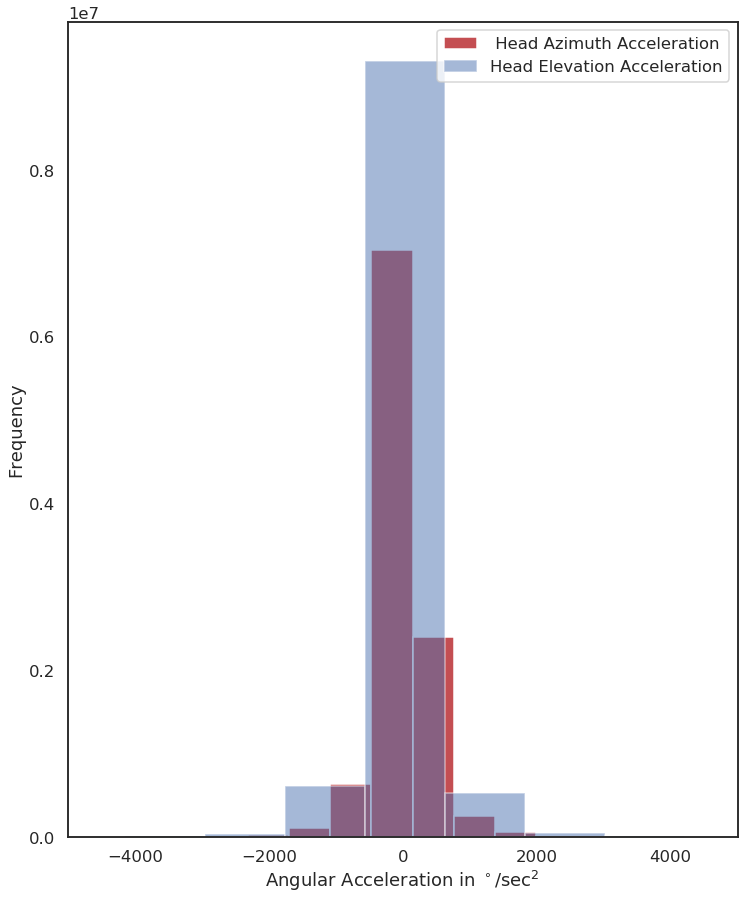

In [108]:
_, ax = plt.subplots(1,1,figsize=(12,15), sharey=True)

(samples_df
.head_acc_h
.plot
.hist(bins=10000, color='r', ax=ax, label=' Head Azimuth Acceleration', legend=True)
)
(samples_df
.head_acc_v
.plot
.hist(bins=10000, color='b', ax=ax, label='Head Elevation Acceleration', legend=True, alpha=0.5)
)
ax.set(xlim=(-5000, 5000), xlabel = 'Angular Acceleration in $^\circ$/sec$^2$')
plt.savefig(f'{PLOT_PATH}/Angular_head_acc_hist.png', transparent=True, bbox_inches='tight', quality=90)

In [81]:
tmpdf = samples_df.query('subjectID==2006 and isFixC==1 and trialID==5')

In [137]:
tmpdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 2662614 to 2662793
Data columns (total 86 columns):
timestamp                           170 non-null float64
leftEye_position_x                  170 non-null float64
leftEye_position_y                  170 non-null float64
leftEye_position_z                  170 non-null float64
leftEye_direction_x                 170 non-null float64
leftEye_direction_y                 170 non-null float64
leftEye_direction_z                 170 non-null float64
leftEye_raycastHitObject            170 non-null object
leftEye_raycastHitLocation_x        170 non-null float64
leftEye_raycastHitLocation_y        170 non-null float64
leftEye_raycastHitLocation_z        170 non-null float64
rightEye_position_x                 170 non-null float64
rightEye_position_y                 170 non-null float64
rightEye_position_z                 170 non-null float64
rightEye_direction_x                170 non-null float64
rightEye_direction_y           

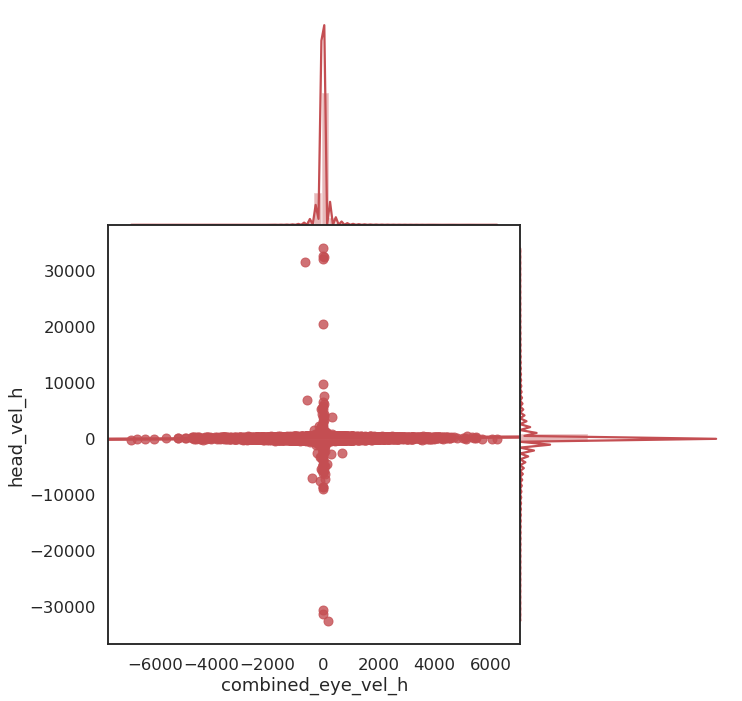

In [282]:
g = sns.jointplot(x= samples_df.combined_eye_vel_h,space=0,color='r', \
                  y=samples_df.head_vel_h, kind="reg", height=10, ratio=2 )
plt.savefig(f'{PLOT_PATH}/head_eye_h.png', transparent=True, bbox_inches='tight', quality=90)

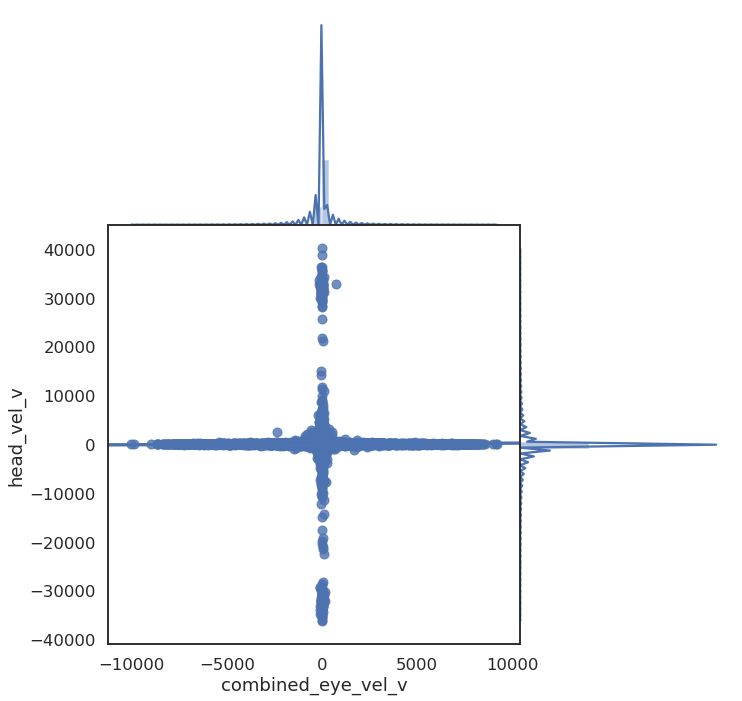

In [286]:
g = sns.jointplot(x= samples_df.combined_eye_vel_v,space=0,color='b', \
                  y=samples_df.head_vel_v, kind="reg", height=10, ratio=2)
plt.savefig(f'{PLOT_PATH}/head_eye_v.png', transparent=True, bbox_inches='tight', quality=90)

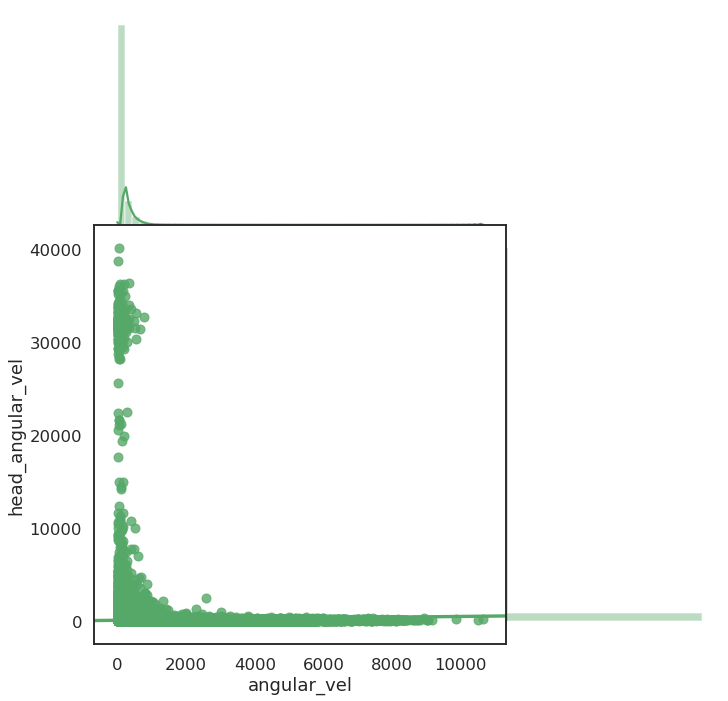

In [341]:
g = sns.jointplot(x= samples_df.angular_vel,space=0,color='g', \
                  y=samples_df.head_angular_vel, kind="reg", height=10, ratio=2)
plt.savefig(f'{PLOT_PATH}/head_eye.png', transparent=True, bbox_inches='tight', quality=90)

## MAD based fixation detection

In [279]:
def simple_mad(angular_vel, thresh = 5):
#     th_1 = np.median(angular_vel)
    if len(angular_vel.shape) == 1:
        angular_vel = angular_vel[:,None]
    median = np.median(angular_vel)
    diff = (angular_vel - median)**2
    diff = np.sqrt(diff)
#     print(diff)
    med_abs_deviation = np.median(diff)
    saccade_thresh = median + thresh*med_abs_deviation
    return saccade_thresh

def at_mad(angular_vel, th_0=200):
    if len(angular_vel.shape) == 1:
        angular_vel = angular_vel[:,None]
    while True:
        angular_vel = angular_vel[angular_vel < th_0]         
        median = np.median(angular_vel)
        diff = (angular_vel - median)**2
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)
        th_1 = median + 3*1.48*med_abs_deviation
#         print(th_0, th_1)
        if (th_0 - th_1)>1:            
            th_0 = th_1
        else:
            saccade_thresh = th_1
            break
    return saccade_thresh

118.92926524829412

207.36799171089766

(-10, 200)

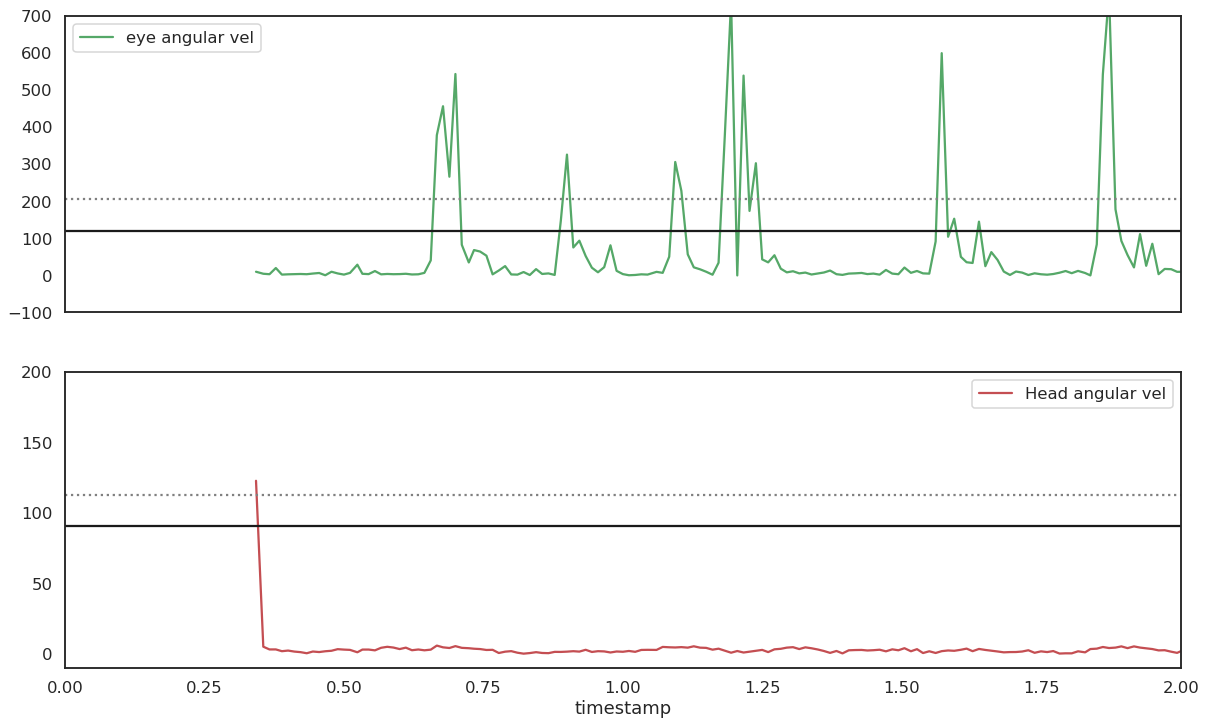

In [352]:
tmpdf = samples_df.query('subjectID==2048 and trialNum==13')
# display(tmpdf.combined_eye_vel_h)
thresh = tmpdf.angular_vel.std()
mad_1 = at_mad(tmpdf.angular_vel)
mad_2 = simple_mad(tmpdf.angular_vel)
mad_3 = simple_mad(tmpdf.head_angular_vel)
mad_4 = at_mad(tmpdf.head_angular_vel)


_, ax = plt.subplots(2, 1, figsize=(20,12), sharex=True, sharey=False)
ax = ax.ravel()

(tmpdf
 .plot('timestamp', 'angular_vel', kind='line', color='g', ax=ax[0], label='eye angular vel', legend=True)
)

(tmpdf
 .plot('timestamp', 'head_angular_vel',kind='line', color='r', ax=ax[1], label='Head angular vel', legend=True)
)

ax[0].axhline(mad_1, ls='-', color='k')
ax[0].axhline(mad_2, ls=':', color='grey')
ax[1].axhline(mad_3, ls=':', color='grey')
ax[1].axhline(mad_4, ls='-', color='k')
display(mad_1, mad_2)
ax[0].set_ylim(-100, 700)
ax[0].set_xlim(0, 2)
ax[1].set_ylim(-10, 200)
# plt.savefig(f'{PLOT_PATH}/at_mad_saccade_2020_3.png', transparent=True, bbox_inches='tight', quality=90)

In [278]:
samples_df['isFixV'] = (samples_df
                       .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                       .angular_vel
                       .transform(lambda x: x < at_mad(x))
                      )

200 202.81758805578087
200 202.81758805578087
200 nan
200 159.20256493299297
159.20256493299297 146.6045932562966
146.6045932562966 142.31813106815463
142.31813106815463 140.31033557634282
140.31033557634282 139.52865940957523
200 159.20256493299297
159.20256493299297 146.6045932562966
146.6045932562966 142.31813106815463
142.31813106815463 140.31033557634282
140.31033557634282 139.52865940957523
200 114.35352088822
114.35352088822 89.72964486589201
89.72964486589201 78.74228198877756
78.74228198877756 73.44741550129959
73.44741550129959 70.9839262545021
70.9839262545021 69.74463777552971
69.74463777552971 68.84765061792424
200 114.35352088822
114.35352088822 89.72964486589201
89.72964486589201 78.74228198877756
78.74228198877756 73.44741550129959
73.44741550129959 70.9839262545021
70.9839262545021 69.74463777552971
69.74463777552971 68.84765061792424
200 176.24246375980707
176.24246375980707 167.16393169542678
167.16393169542678 163.4956755866017
163.4956755866017 162.1238961282115
16

147.41583367551837 133.5617018007867
133.5617018007867 129.14158041822472
129.14158041822472 127.22431795832745
127.22431795832745 126.8498877731856
200 147.41583367551837
147.41583367551837 133.5617018007867
133.5617018007867 129.14158041822472
129.14158041822472 127.22431795832745
127.22431795832745 126.8498877731856
200 177.31450032635954
177.31450032635954 170.92192276163303
170.92192276163303 169.52697441680408
169.52697441680408 169.25918034146645
200 177.31450032635954
177.31450032635954 170.92192276163303
170.92192276163303 169.52697441680408
169.52697441680408 169.25918034146645
200 155.9013448377549
155.9013448377549 144.56212009360868
144.56212009360868 140.87370641352547
140.87370641352547 138.9731043913195
138.9731043913195 138.2384888756597
200 155.9013448377549
155.9013448377549 144.56212009360868
144.56212009360868 140.87370641352547
140.87370641352547 138.9731043913195
138.9731043913195 138.2384888756597
200 159.44271119211453
159.44271119211453 146.85147150871194
146.

200 154.30614119191875
154.30614119191875 140.91162387609643
140.91162387609643 135.71263551049037
135.71263551049037 133.58572652851686
133.58572652851686 132.77981505123108
200 203.11462440276466
200 203.11462440276466
200 198.75907525231347
198.75907525231347 198.78026056012078
200 198.75907525231347
198.75907525231347 198.78026056012078
200 191.9361677170647
191.9361677170647 188.0839513609633
188.0839513609633 186.55511028958412
186.55511028958412 185.7946629601467
200 191.9361677170647
191.9361677170647 188.0839513609633
188.0839513609633 186.55511028958412
186.55511028958412 185.7946629601467
200 172.1961479608371
172.1961479608371 164.09308074816016
164.09308074816016 160.3887673458405
160.3887673458405 158.5156655763606
158.5156655763606 157.6442317791522
200 172.1961479608371
172.1961479608371 164.09308074816016
164.09308074816016 160.3887673458405
160.3887673458405 158.5156655763606
158.5156655763606 157.6442317791522
200 208.15426735545387
200 208.15426735545387
200 195.596

200 192.64761560485903
192.64761560485903 190.42138397819275
190.42138397819275 189.9078558912731
200 192.64761560485903
192.64761560485903 190.42138397819275
190.42138397819275 189.9078558912731
200 164.0481328800341
164.0481328800341 153.184659047803
153.184659047803 148.24973116648454
148.24973116648454 145.3308170250046
145.3308170250046 144.27461639641075
144.27461639641075 143.67714487287674
200 164.0481328800341
164.0481328800341 153.184659047803
153.184659047803 148.24973116648454
148.24973116648454 145.3308170250046
145.3308170250046 144.27461639641075
144.27461639641075 143.67714487287674
200 170.31031843044968
170.31031843044968 160.33239177156466
160.33239177156466 156.23437355413802
156.23437355413802 154.22276950999606
154.22276950999606 153.0927073358794
153.0927073358794 152.6686709463374
200 170.31031843044968
170.31031843044968 160.33239177156466
160.33239177156466 156.23437355413802
156.23437355413802 154.22276950999606
154.22276950999606 153.0927073358794
153.092707

161.25257452405057 160.49145781014047
200 214.24450729726468
200 214.24450729726468
200 185.76398752613335
185.76398752613335 181.06240335650728
181.06240335650728 179.33121711791594
179.33121711791594 178.64017595914453
200 185.76398752613335
185.76398752613335 181.06240335650728
181.06240335650728 179.33121711791594
179.33121711791594 178.64017595914453
200 178.53033973109848
178.53033973109848 170.69181596139472
170.69181596139472 167.6941864763531
167.6941864763531 165.81244352948852
165.81244352948852 165.37273221877476
200 178.53033973109848
178.53033973109848 170.69181596139472
170.69181596139472 167.6941864763531
167.6941864763531 165.81244352948852
165.81244352948852 165.37273221877476
200 202.94246603910577
200 202.94246603910577
200 168.58832745004514
168.58832745004514 157.10870697224112
157.10870697224112 153.56995703567662
153.56995703567662 151.9716266125659
151.9716266125659 151.2171643606508
200 168.58832745004514
168.58832745004514 157.10870697224112
157.1087069722411

134.56455229166198 132.9758476532504
132.9758476532504 132.17906346772224
200 165.35909939550277
165.35909939550277 154.9645946014714
154.9645946014714 150.3007293947702
150.3007293947702 148.74731496313137
148.74731496313137 148.01031876793687
200 165.35909939550277
165.35909939550277 154.9645946014714
154.9645946014714 150.3007293947702
150.3007293947702 148.74731496313137
148.74731496313137 148.01031876793687
200 166.46873912794635
166.46873912794635 155.07658249658766
155.07658249658766 151.11646848640808
151.11646848640808 148.63862965353803
148.63862965353803 146.69169032130387
146.69169032130387 146.25870494428665
200 166.46873912794635
166.46873912794635 155.07658249658766
155.07658249658766 151.11646848640808
151.11646848640808 148.63862965353803
148.63862965353803 146.69169032130387
146.69169032130387 146.25870494428665
200 146.59375844491743
146.59375844491743 129.10362940403834
129.10362940403834 122.80106741866541
122.80106741866541 120.37030424037711
120.37030424037711 11

200 214.90400897870458
200 190.03700853165665
190.03700853165665 186.00691861434296
186.00691861434296 183.7559563749139
183.7559563749139 182.94537507359033
200 190.03700853165665
190.03700853165665 186.00691861434296
186.00691861434296 183.7559563749139
183.7559563749139 182.94537507359033
200 199.73662858760935
200 199.73662858760935
200 195.169242442844
195.169242442844 193.07101479267706
193.07101479267706 191.5532265736442
191.5532265736442 190.9953912896141
200 195.169242442844
195.169242442844 193.07101479267706
193.07101479267706 191.5532265736442
191.5532265736442 190.9953912896141
200 189.97919912582938
189.97919912582938 186.10240284938365
186.10240284938365 184.86367404423066
184.86367404423066 184.4936891910603
200 189.97919912582938
189.97919912582938 186.10240284938365
186.10240284938365 184.86367404423066
184.86367404423066 184.4936891910603
200 200.12105169258865
200 200.12105169258865
200 201.24918074583783
200 201.24918074583783
200 214.0056578744966
200 214.0056578

160.87690921644844 159.16603695755794
159.16603695755794 157.84417297614112
157.84417297614112 157.42398977633542
200 177.87737098777592
177.87737098777592 167.91201076460243
167.91201076460243 163.48037714194342
163.48037714194342 160.87690921644844
160.87690921644844 159.16603695755794
159.16603695755794 157.84417297614112
157.84417297614112 157.42398977633542
200 167.97494409898428
167.97494409898428 157.44061809191268
157.44061809191268 153.9575241388709
153.9575241388709 152.55851082822738
152.55851082822738 151.98225867046665
200 167.97494409898428
167.97494409898428 157.44061809191268
157.44061809191268 153.9575241388709
153.9575241388709 152.55851082822738
152.55851082822738 151.98225867046665
200 151.3023398369066
151.3023398369066 139.0865703613909
139.0865703613909 135.28574392008085
135.28574392008085 133.85319886826093
133.85319886826093 133.23875121822118
200 151.3023398369066
151.3023398369066 139.0865703613909
139.0865703613909 135.28574392008085
135.28574392008085 133.

132.06004666841457 126.61186146880746
126.61186146880746 124.45590277412474
124.45590277412474 123.57877989672615
200 140.9324834456213
140.9324834456213 125.36093281680073
125.36093281680073 119.69163151629807
119.69163151629807 117.39561414027348
117.39561414027348 116.21084013194952
116.21084013194952 115.80225606818843
200 140.9324834456213
140.9324834456213 125.36093281680073
125.36093281680073 119.69163151629807
119.69163151629807 117.39561414027348
117.39561414027348 116.21084013194952
116.21084013194952 115.80225606818843
200 141.63154011350986
141.63154011350986 126.93563072669164
126.93563072669164 121.79682292940892
121.79682292940892 119.92512311142525
119.92512311142525 119.11105781713462
200 141.63154011350986
141.63154011350986 126.93563072669164
126.93563072669164 121.79682292940892
121.79682292940892 119.92512311142525
119.92512311142525 119.11105781713462
200 137.5637175081933
137.5637175081933 120.32524192981084
120.32524192981084 113.09877600295967
113.0987760029596

185.0354199673078 180.11071496339918
180.11071496339918 177.69355332269015
177.69355332269015 177.21180015587134
200 185.0354199673078
185.0354199673078 180.11071496339918
180.11071496339918 177.69355332269015
177.69355332269015 177.21180015587134
200 179.40088459350594
179.40088459350594 168.66370531188744
168.66370531188744 163.59861969326562
163.59861969326562 162.35631266853983
162.35631266853983 161.83500758385364
200 179.40088459350594
179.40088459350594 168.66370531188744
168.66370531188744 163.59861969326562
163.59861969326562 162.35631266853983
162.35631266853983 161.83500758385364
200 147.7833817337924
147.7833817337924 129.8572385276794
129.8572385276794 122.41267617100523
122.41267617100523 118.26510038724258
118.26510038724258 116.04124205154972
116.04124205154972 114.83001821471052
114.83001821471052 114.26244186018849
200 147.7833817337924
147.7833817337924 129.8572385276794
129.8572385276794 122.41267617100523
122.41267617100523 118.26510038724258
118.26510038724258 116

126.16840605039954 123.66232009571249
123.66232009571249 122.51204801410888
122.51204801410888 122.08853041037693
200 145.62464878359677
145.62464878359677 131.91501150662754
131.91501150662754 126.16840605039954
126.16840605039954 123.66232009571249
123.66232009571249 122.51204801410888
122.51204801410888 122.08853041037693
200 138.37508996664585
138.37508996664585 118.61087177513153
118.61087177513153 110.07485756551401
110.07485756551401 104.61127876556955
104.61127876556955 102.11724237900575
102.11724237900575 100.40593187927887
100.40593187927887 98.60570094281339
98.60570094281339 98.06115813395073
200 138.37508996664585
138.37508996664585 118.61087177513153
118.61087177513153 110.07485756551401
110.07485756551401 104.61127876556955
104.61127876556955 102.11724237900575
102.11724237900575 100.40593187927887
100.40593187927887 98.60570094281339
98.60570094281339 98.06115813395073
200 128.46021284684167
128.46021284684167 112.42573723546896
112.42573723546896 106.49646108775883
10

200 189.27731195950625
189.27731195950625 184.08226781897304
184.08226781897304 182.32421447193877
182.32421447193877 181.73503236195168
200 189.27731195950625
189.27731195950625 184.08226781897304
184.08226781897304 182.32421447193877
182.32421447193877 181.73503236195168
200 176.75276172875317
176.75276172875317 167.71625080890823
167.71625080890823 164.44410873055745
164.44410873055745 162.96313109326886
162.96313109326886 162.02600766768313
200 176.75276172875317
176.75276172875317 167.71625080890823
167.71625080890823 164.44410873055745
164.44410873055745 162.96313109326886
162.96313109326886 162.02600766768313
200 172.24857828088994
172.24857828088994 161.48876778705227
161.48876778705227 156.85810608179833
156.85810608179833 155.53088391979037
155.53088391979037 154.88199684014364
200 172.24857828088994
172.24857828088994 161.48876778705227
161.48876778705227 156.85810608179833
156.85810608179833 155.53088391979037
155.53088391979037 154.88199684014364
200 173.32957797335706
173

84.12155443713439 82.76072602911117
82.76072602911117 82.09581926136849
200 129.30742886516325
129.30742886516325 107.49737289758272
107.49737289758272 100.58315113977999
100.58315113977999 98.33514494057272
98.33514494057272 96.84348733593859
96.84348733593859 96.30236593701223
200 129.30742886516325
129.30742886516325 107.49737289758272
107.49737289758272 100.58315113977999
100.58315113977999 98.33514494057272
98.33514494057272 96.84348733593859
96.84348733593859 96.30236593701223
200 123.42204167214766
123.42204167214766 99.92937009656062
99.92937009656062 92.9238208277049
92.9238208277049 90.20620266514538
90.20620266514538 88.62067543953074
88.62067543953074 88.245370397974
200 123.42204167214766
123.42204167214766 99.92937009656062
99.92937009656062 92.9238208277049
92.9238208277049 90.20620266514538
90.20620266514538 88.62067543953074
88.62067543953074 88.245370397974
200 107.61595522424972
107.61595522424972 86.05994177065477
86.05994177065477 77.82219679005604
77.8221967900560

110.1807788915321 97.58007627443305
97.58007627443305 90.89777465002666
90.89777465002666 86.67589068813496
86.67589068813496 83.78796030514562
83.78796030514562 81.67069159641368
81.67069159641368 80.5127260137217
80.5127260137217 79.6020976905318
200 134.93104477216338
134.93104477216338 110.1807788915321
110.1807788915321 97.58007627443305
97.58007627443305 90.89777465002666
90.89777465002666 86.67589068813496
86.67589068813496 83.78796030514562
83.78796030514562 81.67069159641368
81.67069159641368 80.5127260137217
80.5127260137217 79.6020976905318
200 145.24768687103273
145.24768687103273 127.36103536162639
127.36103536162639 119.94532382153801
119.94532382153801 116.02300203567964
116.02300203567964 113.98741838255698
113.98741838255698 113.2349460888222
200 145.24768687103273
145.24768687103273 127.36103536162639
127.36103536162639 119.94532382153801
119.94532382153801 116.02300203567964
116.02300203567964 113.98741838255698
113.98741838255698 113.2349460888222
200 153.2455237200

137.81318988325782 136.19533868226807
136.19533868226807 135.18462546007447
135.18462546007447 135.00292868049084
200 174.06381144617063
174.06381144617063 165.36553974629155
165.36553974629155 162.26233660003783
162.26233660003783 161.19377054385097
161.19377054385097 160.85410185448842
200 174.06381144617063
174.06381144617063 165.36553974629155
165.36553974629155 162.26233660003783
162.26233660003783 161.19377054385097
161.19377054385097 160.85410185448842
200 151.8996627909193
151.8996627909193 136.21211321313493
136.21211321313493 130.2605287357914
130.2605287357914 127.25774057009856
127.25774057009856 126.15375471559975
126.15375471559975 125.72930280702167
200 151.8996627909193
151.8996627909193 136.21211321313493
136.21211321313493 130.2605287357914
130.2605287357914 127.25774057009856
127.25774057009856 126.15375471559975
126.15375471559975 125.72930280702167
200 191.83827040767804
191.83827040767804 187.9778203484526
187.9778203484526 186.58344276553368
186.58344276553368 18

143.26897867918893 141.49905889000766
141.49905889000766 140.4379727901421
140.4379727901421 140.04457526246466
200 203.9157138851351
200 203.9157138851351
200 176.53961202326929
176.53961202326929 165.3898693456722
165.3898693456722 160.2168983742668
160.2168983742668 158.5492175209182
158.5492175209182 157.45535412400196
157.45535412400196 156.99842683229326
200 176.53961202326929
176.53961202326929 165.3898693456722
165.3898693456722 160.2168983742668
160.2168983742668 158.5492175209182
158.5492175209182 157.45535412400196
157.45535412400196 156.99842683229326
200 154.16512017417833
154.16512017417833 139.88249607890072
139.88249607890072 133.81311012226382
133.81311012226382 131.44457179148014
131.44457179148014 130.62723220159475
200 154.16512017417833
154.16512017417833 139.88249607890072
139.88249607890072 133.81311012226382
133.81311012226382 131.44457179148014
131.44457179148014 130.62723220159475
200 166.58150946322934
166.58150946322934 155.3457409438415
155.3457409438415 14

200 151.87037866398165
151.87037866398165 137.23605331033423
137.23605331033423 132.4279213204319
132.4279213204319 129.91311600079882
129.91311600079882 128.51740910885448
128.51740910885448 128.0689055391054
200 151.87037866398165
151.87037866398165 137.23605331033423
137.23605331033423 132.4279213204319
132.4279213204319 129.91311600079882
129.91311600079882 128.51740910885448
128.51740910885448 128.0689055391054
200 151.69856275841022
151.69856275841022 138.99762410981174
138.99762410981174 135.2174599442397
135.2174599442397 132.73799350158646
132.73799350158646 131.71105537625485
131.71105537625485 131.36098227267945
200 151.69856275841022
151.69856275841022 138.99762410981174
138.99762410981174 135.2174599442397
135.2174599442397 132.73799350158646
132.73799350158646 131.71105537625485
131.71105537625485 131.36098227267945
200 143.9518817821337
143.9518817821337 128.22869432020738
128.22869432020738 122.11088972898048
122.11088972898048 119.90660970005257
119.90660970005257 118.

170.46213358125158 169.8836188033296
200 183.15630372512408
183.15630372512408 175.63364090593694
175.63364090593694 173.5351143986431
173.5351143986431 172.66554645443986
200 183.15630372512408
183.15630372512408 175.63364090593694
175.63364090593694 173.5351143986431
173.5351143986431 172.66554645443986
200 179.96996440647686
179.96996440647686 172.92535011411138
172.92535011411138 171.13327679102747
171.13327679102747 170.1813312567049
200 179.96996440647686
179.96996440647686 172.92535011411138
172.92535011411138 171.13327679102747
171.13327679102747 170.1813312567049
200 184.60799448174797
184.60799448174797 178.82021307079762
178.82021307079762 175.9793192365146
175.9793192365146 175.10057326643934
200 184.60799448174797
184.60799448174797 178.82021307079762
178.82021307079762 175.9793192365146
175.9793192365146 175.10057326643934
200 195.4217628733046
195.4217628733046 192.85535266800645
192.85535266800645 192.23094133206374
200 195.4217628733046
195.4217628733046 192.8553526680

200 252.6126467180199
200 252.6126467180199
200 161.6575518955668
161.6575518955668 148.0184632722944
148.0184632722944 142.11325404097215
142.11325404097215 139.0256534828373
139.0256534828373 138.05669905514702
200 161.6575518955668
161.6575518955668 148.0184632722944
148.0184632722944 142.11325404097215
142.11325404097215 139.0256534828373
139.0256534828373 138.05669905514702
200 170.20502667171547
170.20502667171547 158.20815038989025
158.20815038989025 151.01135265406396
151.01135265406396 146.8758953112266
146.8758953112266 144.55637586990926
144.55637586990926 143.79791356705582
200 170.20502667171547
170.20502667171547 158.20815038989025
158.20815038989025 151.01135265406396
151.01135265406396 146.8758953112266
146.8758953112266 144.55637586990926
144.55637586990926 143.79791356705582
200 152.19323032221058
152.19323032221058 133.84610240959637
133.84610240959637 126.49203838116776
126.49203838116776 123.55807986135933
123.55807986135933 121.85478400865227
121.85478400865227 12

200 135.04289395906852
135.04289395906852 122.53840018753942
122.53840018753942 118.5326093662478
118.5326093662478 116.5489437522958
116.5489437522958 115.9235637723091
200 135.04289395906852
135.04289395906852 122.53840018753942
122.53840018753942 118.5326093662478
118.5326093662478 116.5489437522958
116.5489437522958 115.9235637723091
200 149.88996550198863
149.88996550198863 136.89094951608254
136.89094951608254 132.93280566173982
132.93280566173982 130.48428687077103
130.48428687077103 129.80166218138493
200 149.88996550198863
149.88996550198863 136.89094951608254
136.89094951608254 132.93280566173982
132.93280566173982 130.48428687077103
130.48428687077103 129.80166218138493
200 138.32345714061904
138.32345714061904 123.34562735478886
123.34562735478886 117.09033841233745
117.09033841233745 114.52173219433077
114.52173219433077 113.69385240968957
200 138.32345714061904
138.32345714061904 123.34562735478886
123.34562735478886 117.09033841233745
117.09033841233745 114.5217321943307

200 182.25264126970367
182.25264126970367 176.3414650091263
176.3414650091263 173.22577931259687
173.22577931259687 172.22808303541916
200 182.25264126970367
182.25264126970367 176.3414650091263
176.3414650091263 173.22577931259687
173.22577931259687 172.22808303541916
200 180.14670239725478
180.14670239725478 170.6796867960574
170.6796867960574 166.75771602933776
166.75771602933776 165.174494864536
165.174494864536 163.93315963496974
163.93315963496974 163.1593877380843
200 180.14670239725478
180.14670239725478 170.6796867960574
170.6796867960574 166.75771602933776
166.75771602933776 165.174494864536
165.174494864536 163.93315963496974
163.93315963496974 163.1593877380843
200 194.11232125552925
194.11232125552925 192.17666778796575
192.17666778796575 191.02221205133077
191.02221205133077 190.85550764244917
200 194.11232125552925
194.11232125552925 192.17666778796575
192.17666778796575 191.02221205133077
191.02221205133077 190.85550764244917
200 183.55838560135228
183.55838560135228 17

174.96662640047808 171.9621745385681
171.9621745385681 170.35976276948583
170.35976276948583 169.4931033803027
200 125.42835737020017
125.42835737020017 107.22653389003132
107.22653389003132 100.2008863272678
100.2008863272678 97.77795604045265
97.77795604045265 97.047802608231
200 125.42835737020017
125.42835737020017 107.22653389003132
107.22653389003132 100.2008863272678
100.2008863272678 97.77795604045265
97.77795604045265 97.047802608231
200 124.22675685459836
124.22675685459836 102.1503899677808
102.1503899677808 95.41689104584887
95.41689104584887 91.82536028242221
91.82536028242221 90.4637111549338
90.4637111549338 90.19153661861034
200 124.22675685459836
124.22675685459836 102.1503899677808
102.1503899677808 95.41689104584887
95.41689104584887 91.82536028242221
91.82536028242221 90.4637111549338
90.4637111549338 90.19153661861034
200 133.6407081399184
133.6407081399184 115.61280660493631
115.61280660493631 108.06371444023748
108.06371444023748 104.27683004698466
104.2768300469

121.62896323352109 120.61157702396207
120.61157702396207 120.27609994463968
200 144.16742990832807
144.16742990832807 129.2217543198424
129.2217543198424 123.92218612742991
123.92218612742991 121.62896323352109
121.62896323352109 120.61157702396207
120.61157702396207 120.27609994463968
200 148.9523711498299
148.9523711498299 134.03616525841073
134.03616525841073 127.33807977064151
127.33807977064151 125.06055403687589
125.06055403687589 123.903164315571
123.903164315571 123.38393573516048
200 148.9523711498299
148.9523711498299 134.03616525841073
134.03616525841073 127.33807977064151
127.33807977064151 125.06055403687589
125.06055403687589 123.903164315571
123.903164315571 123.38393573516048
200 140.09596924622997
140.09596924622997 120.77954391580455
120.77954391580455 112.33989664517739
112.33989664517739 108.22772255579534
108.22772255579534 106.17906686261875
106.17906686261875 105.07335676233473
105.07335676233473 104.55477123538424
200 140.09596924622997
140.09596924622997 120.77

146.73561600158527 141.80447549263346
141.80447549263346 139.51886497246147
139.51886497246147 138.59168945447476
200 159.21811716210652
159.21811716210652 146.73561600158527
146.73561600158527 141.80447549263346
141.80447549263346 139.51886497246147
139.51886497246147 138.59168945447476
200 172.0114549677778
172.0114549677778 162.26694410135332
162.26694410135332 159.034924505971
159.034924505971 158.1687462303209
200 172.0114549677778
172.0114549677778 162.26694410135332
162.26694410135332 159.034924505971
159.034924505971 158.1687462303209
200 143.23396874303657
143.23396874303657 125.4287717540117
125.4287717540117 117.813142559404
117.813142559404 113.95435411794625
113.95435411794625 111.97335994498167
111.97335994498167 111.28427096815875
200 143.23396874303657
143.23396874303657 125.4287717540117
125.4287717540117 117.813142559404
117.813142559404 113.95435411794625
113.95435411794625 111.97335994498167
111.97335994498167 111.28427096815875
200 184.4355159386765
184.43551593867

155.69218201248776 150.23443382475853
150.23443382475853 148.11155376606303
148.11155376606303 147.47247422786364
200 156.6756033281734
156.6756033281734 137.0427623264518
137.0427623264518 129.2385561616012
129.2385561616012 125.59107433052472
125.59107433052472 124.33206124641987
124.33206124641987 123.98464254529524
200 156.6756033281734
156.6756033281734 137.0427623264518
137.0427623264518 129.2385561616012
129.2385561616012 125.59107433052472
125.59107433052472 124.33206124641987
124.33206124641987 123.98464254529524
200 163.17560801333357
163.17560801333357 150.47092584290363
150.47092584290363 145.55973330111598
145.55973330111598 143.45656043776094
143.45656043776094 142.2601280618194
142.2601280618194 141.56736513832072
200 163.17560801333357
163.17560801333357 150.47092584290363
150.47092584290363 145.55973330111598
145.55973330111598 143.45656043776094
143.45656043776094 142.2601280618194
142.2601280618194 141.56736513832072
200 163.58689872088837
163.58689872088837 151.5404

200 114.22770347831957
114.22770347831957 91.9469178271776
91.9469178271776 83.55720377672651
83.55720377672651 80.83591934022365
80.83591934022365 79.4264983878297
79.4264983878297 78.84674727509719
200 114.22770347831957
114.22770347831957 91.9469178271776
91.9469178271776 83.55720377672651
83.55720377672651 80.83591934022365
80.83591934022365 79.4264983878297
79.4264983878297 78.84674727509719
200 122.4464754796642
122.4464754796642 99.93842282030272
99.93842282030272 90.9222979596836
90.9222979596836 87.33409363351934
87.33409363351934 85.68571100189195
85.68571100189195 84.99471849876883
200 122.4464754796642
122.4464754796642 99.93842282030272
99.93842282030272 90.9222979596836
90.9222979596836 87.33409363351934
87.33409363351934 85.68571100189195
85.68571100189195 84.99471849876883
200 122.93934637823509
122.93934637823509 104.319804268767
104.319804268767 98.31543429442245
98.31543429442245 95.33192688440208
95.33192688440208 93.87345222485106
93.87345222485106 93.2153357082519

176.5388361216581 176.03376348286628
200 194.78523236722617
194.78523236722617 192.6415811664322
192.6415811664322 191.89185752780372
200 194.78523236722617
194.78523236722617 192.6415811664322
192.6415811664322 191.89185752780372
200 183.49027044851778
183.49027044851778 176.86617209712358
176.86617209712358 174.26661799401325
174.26661799401325 172.95048641422648
172.95048641422648 172.3749689970345
200 183.49027044851778
183.49027044851778 176.86617209712358
176.86617209712358 174.26661799401325
174.26661799401325 172.95048641422648
172.95048641422648 172.3749689970345
200 189.9448515274911
189.9448515274911 185.24146288436714
185.24146288436714 183.01215528751752
183.01215528751752 182.3394290594416
200 189.9448515274911
189.9448515274911 185.24146288436714
185.24146288436714 183.01215528751752
183.01215528751752 182.3394290594416
200 171.54483172326542
171.54483172326542 161.5364629974158
161.5364629974158 156.8182445918331
156.8182445918331 155.43233992682568
155.43233992682568 1

200 113.88557166871682
113.88557166871682 94.15129538269191
94.15129538269191 87.08761920881867
87.08761920881867 83.21434541655148
83.21434541655148 81.49314385622
81.49314385622 80.84910242495025
200 113.88557166871682
113.88557166871682 94.15129538269191
94.15129538269191 87.08761920881867
87.08761920881867 83.21434541655148
83.21434541655148 81.49314385622
81.49314385622 80.84910242495025
200 134.9417980069664
134.9417980069664 116.68823577096833
116.68823577096833 109.05468849383087
109.05468849383087 105.76420266456388
105.76420266456388 103.7604654311223
103.7604654311223 102.92695777628917
200 134.9417980069664
134.9417980069664 116.68823577096833
116.68823577096833 109.05468849383087
109.05468849383087 105.76420266456388
105.76420266456388 103.7604654311223
103.7604654311223 102.92695777628917
200 152.7531784248096
152.7531784248096 137.9536231168907
137.9536231168907 131.5204111459664
131.5204111459664 128.22180979928288
128.22180979928288 126.73392403185758
126.7339240318575

200 162.73952095674952
162.73952095674952 151.04798807873954
151.04798807873954 147.3376675608735
147.3376675608735 146.06262792894813
146.06262792894813 145.38277783756092
200 162.73952095674952
162.73952095674952 151.04798807873954
151.04798807873954 147.3376675608735
147.3376675608735 146.06262792894813
146.06262792894813 145.38277783756092
200 168.13720565403656
168.13720565403656 155.33164794094083
155.33164794094083 150.7661976555767
150.7661976555767 148.19513307798928
148.19513307798928 147.29343973879767
200 168.13720565403656
168.13720565403656 155.33164794094083
155.33164794094083 150.7661976555767
150.7661976555767 148.19513307798928
148.19513307798928 147.29343973879767
200 170.06196701311836
170.06196701311836 160.0264155493514
160.0264155493514 156.31738289624732
156.31738289624732 154.4833704937113
154.4833704937113 153.8332609970621
200 170.06196701311836
170.06196701311836 160.0264155493514
160.0264155493514 156.31738289624732
156.31738289624732 154.4833704937113
154.

120.72839520120831 100.95783935958067
100.95783935958067 92.13594928646927
92.13594928646927 88.0823496074599
88.0823496074599 86.24868033873287
86.24868033873287 85.0211202142018
85.0211202142018 84.48854467897581
200 120.72839520120831
120.72839520120831 100.95783935958067
100.95783935958067 92.13594928646927
92.13594928646927 88.0823496074599
88.0823496074599 86.24868033873287
86.24868033873287 85.0211202142018
85.0211202142018 84.48854467897581
200 128.59178979642434
128.59178979642434 110.41152417726104
110.41152417726104 102.59807174252498
102.59807174252498 100.07240354154207
100.07240354154207 99.18158714966405
200 128.59178979642434
128.59178979642434 110.41152417726104
110.41152417726104 102.59807174252498
102.59807174252498 100.07240354154207
100.07240354154207 99.18158714966405
200 157.32024999479376
157.32024999479376 142.27873498108198
142.27873498108198 136.07634588244304
136.07634588244304 133.45032399679903
133.45032399679903 132.180345425263
132.180345425263 131.87143

200 162.04378210435993
162.04378210435993 151.6599033597778
151.6599033597778 148.23968527693012
148.23968527693012 147.4149761104661
200 167.76428348102866
167.76428348102866 154.851129004269
154.851129004269 149.95928599527065
149.95928599527065 147.9962167914676
147.9962167914676 147.20177228133372
200 167.76428348102866
167.76428348102866 154.851129004269
154.851129004269 149.95928599527065
149.95928599527065 147.9962167914676
147.9962167914676 147.20177228133372
200 151.30235688931975
151.30235688931975 137.27086804380832
137.27086804380832 132.09622686557242
132.09622686557242 129.620990924859
129.620990924859 128.54662619606415
128.54662619606415 128.03879699928012
200 151.30235688931975
151.30235688931975 137.27086804380832
137.27086804380832 132.09622686557242
132.09622686557242 129.620990924859
129.620990924859 128.54662619606415
128.54662619606415 128.03879699928012
200 175.18925165366946
175.18925165366946 164.4994180553291
164.4994180553291 160.72455668453097
160.724556684

136.03910639161396 129.4279815820923
129.4279815820923 126.09453574117389
126.09453574117389 123.6702951421661
123.6702951421661 122.55084194577893
122.55084194577893 122.4086646185697
200 152.54064532669486
152.54064532669486 136.03910639161396
136.03910639161396 129.4279815820923
129.4279815820923 126.09453574117389
126.09453574117389 123.6702951421661
123.6702951421661 122.55084194577893
122.55084194577893 122.4086646185697
200 170.45107377932078
170.45107377932078 159.87503438914237
159.87503438914237 155.54218816935472
155.54218816935472 153.92781259706533
153.92781259706533 153.38075603349077
200 170.45107377932078
170.45107377932078 159.87503438914237
159.87503438914237 155.54218816935472
155.54218816935472 153.92781259706533
153.92781259706533 153.38075603349077
200 167.561063464493
167.561063464493 155.25494147344654
155.25494147344654 150.9358481508362
150.9358481508362 149.05730923486018
149.05730923486018 148.51903906372638
200 167.561063464493
167.561063464493 155.25494147

179.22731466434934 172.59469534256664
172.59469534256664 170.5369181371591
170.5369181371591 170.01494039761357
200 179.22731466434934
179.22731466434934 172.59469534256664
172.59469534256664 170.5369181371591
170.5369181371591 170.01494039761357
200 161.33760310572984
161.33760310572984 145.49442052578647
145.49442052578647 135.96434303620816
135.96434303620816 131.38334094403183
131.38334094403183 129.98572953829813
129.98572953829813 129.26550146097728
200 161.33760310572984
161.33760310572984 145.49442052578647
145.49442052578647 135.96434303620816
135.96434303620816 131.38334094403183
131.38334094403183 129.98572953829813
129.98572953829813 129.26550146097728
200 188.44600267976037
188.44600267976037 185.55501785265753
185.55501785265753 184.44400539566183
184.44400539566183 184.41614939685167
200 188.44600267976037
188.44600267976037 185.55501785265753
185.55501785265753 184.44400539566183
184.44400539566183 184.41614939685167
200 179.22579935218016
179.22579935218016 172.7001587

133.54602049059608 130.4139163408414
130.4139163408414 129.22055114773622
129.22055114773622 129.12587441413774
200 139.86175890817458
139.86175890817458 126.90603671262822
126.90603671262822 123.32305796080456
123.32305796080456 121.34065122912926
121.34065122912926 120.71459719300127
200 139.86175890817458
139.86175890817458 126.90603671262822
126.90603671262822 123.32305796080456
123.32305796080456 121.34065122912926
121.34065122912926 120.71459719300127
200 139.5674839017883
139.5674839017883 127.98128102429949
127.98128102429949 125.02485624334983
125.02485624334983 123.50030145855293
123.50030145855293 122.98331932256465
200 139.5674839017883
139.5674839017883 127.98128102429949
127.98128102429949 125.02485624334983
125.02485624334983 123.50030145855293
123.50030145855293 122.98331932256465
200 148.35564480336456
148.35564480336456 134.74974240938246
134.74974240938246 130.4914345599619
130.4914345599619 128.85065212041843
128.85065212041843 128.09359206342702
200 148.35564480336

159.0360342869771 157.61838336812804
157.61838336812804 156.88615471871768
200 173.07465028175477
173.07465028175477 163.3810464398187
163.3810464398187 159.0360342869771
159.0360342869771 157.61838336812804
157.61838336812804 156.88615471871768
200 178.2289509810442
178.2289509810442 172.00207181377567
172.00207181377567 169.8959410896196
169.8959410896196 167.75363465178344
167.75363465178344 167.3222334194652
200 178.2289509810442
178.2289509810442 172.00207181377567
172.00207181377567 169.8959410896196
169.8959410896196 167.75363465178344
167.75363465178344 167.3222334194652
200 154.12450585701814
154.12450585701814 141.8281368070742
141.8281368070742 136.34614569120362
136.34614569120362 134.19731928218127
134.19731928218127 134.2738239822401
200 154.12450585701814
154.12450585701814 141.8281368070742
141.8281368070742 136.34614569120362
136.34614569120362 134.19731928218127
134.19731928218127 134.2738239822401
200 164.45694688230407
164.45694688230407 154.16418454505828
154.16418

200 138.63883411660518
138.63883411660518 120.88309775131802
120.88309775131802 113.61861695852433
113.61861695852433 109.5292742336527
109.5292742336527 108.01462601397958
108.01462601397958 107.20305759890881
200 138.63883411660518
138.63883411660518 120.88309775131802
120.88309775131802 113.61861695852433
113.61861695852433 109.5292742336527
109.5292742336527 108.01462601397958
108.01462601397958 107.20305759890881
200 164.57237327759248
164.57237327759248 150.18696929867195
150.18696929867195 144.68581718134567
144.68581718134567 142.7067261555981
142.7067261555981 140.64634949195712
140.64634949195712 139.94004493088732
200 164.57237327759248
164.57237327759248 150.18696929867195
150.18696929867195 144.68581718134567
144.68581718134567 142.7067261555981
142.7067261555981 140.64634949195712
140.64634949195712 139.94004493088732
200 164.4533444202517
164.4533444202517 151.16060119670843
151.16060119670843 144.24280033492045
144.24280033492045 141.21791966627066
141.21791966627066 14

90.56525233030432 86.78771422220572
86.78771422220572 85.2468381278806
85.2468381278806 84.54100528941068
200 144.1865159929593
144.1865159929593 129.05488846094468
129.05488846094468 123.18182648435796
123.18182648435796 120.88930911380953
120.88930911380953 120.6597208576764
200 144.1865159929593
144.1865159929593 129.05488846094468
129.05488846094468 123.18182648435796
123.18182648435796 120.88930911380953
120.88930911380953 120.6597208576764
200 129.53103239044435
129.53103239044435 108.32027826528572
108.32027826528572 99.5066657150116
99.5066657150116 95.64667041677114
95.64667041677114 93.7721311448824
93.7721311448824 92.55477461229893
92.55477461229893 91.87429582310956
200 129.53103239044435
129.53103239044435 108.32027826528572
108.32027826528572 99.5066657150116
99.5066657150116 95.64667041677114
95.64667041677114 93.7721311448824
93.7721311448824 92.55477461229893
92.55477461229893 91.87429582310956
200 150.0509561119593
150.0509561119593 134.46690358355994
134.46690358355

185.19871965230703 183.58206127152982
183.58206127152982 182.7740981508501
200 188.6531525327089
188.6531525327089 185.19871965230703
185.19871965230703 183.58206127152982
183.58206127152982 182.7740981508501
200 144.93249959986312
144.93249959986312 125.30110134926679
125.30110134926679 115.94806922087524
115.94806922087524 111.52328642741082
111.52328642741082 109.47766746863071
109.47766746863071 108.1233402660714
108.1233402660714 107.47440320859478
200 144.93249959986312
144.93249959986312 125.30110134926679
125.30110134926679 115.94806922087524
115.94806922087524 111.52328642741082
111.52328642741082 109.47766746863071
109.47766746863071 108.1233402660714
108.1233402660714 107.47440320859478
200 154.9074751283091
154.9074751283091 137.73659497815652
137.73659497815652 129.79963884624283
129.79963884624283 125.44371254395685
125.44371254395685 123.63260189722106
123.63260189722106 123.03473312716434
200 154.9074751283091
154.9074751283091 137.73659497815652
137.73659497815652 129.

137.23200153313198 136.53740499178855
200 157.5892665631885
157.5892665631885 144.6804991397849
144.6804991397849 139.0869004681541
139.0869004681541 137.23200153313198
137.23200153313198 136.53740499178855
200 171.70533637579473
171.70533637579473 161.0216193782602
161.0216193782602 156.95796055837135
156.95796055837135 155.02792270960623
155.02792270960623 154.16635000775517
200 171.70533637579473
171.70533637579473 161.0216193782602
161.0216193782602 156.95796055837135
156.95796055837135 155.02792270960623
155.02792270960623 154.16635000775517
200 164.95693024270423
164.95693024270423 151.5563240366748
151.5563240366748 144.97354553500907
144.97354553500907 142.58292034208074
142.58292034208074 140.77557976059705
140.77557976059705 139.94668702268808
200 164.95693024270423
164.95693024270423 151.5563240366748
151.5563240366748 144.97354553500907
144.97354553500907 142.58292034208074
142.58292034208074 140.77557976059705
140.77557976059705 139.94668702268808
200 206.24560241051446
20

151.06755418828493 148.7355333801452
148.7355333801452 147.60659322443414
147.60659322443414 147.19785694277542
200 169.31933986494568
169.31933986494568 156.8144377730478
156.8144377730478 151.06755418828493
151.06755418828493 148.7355333801452
148.7355333801452 147.60659322443414
147.60659322443414 147.19785694277542
200 179.55644343251066
179.55644343251066 171.62310775194115
171.62310775194115 168.94803436255336
168.94803436255336 168.07166689626115
200 179.55644343251066
179.55644343251066 171.62310775194115
171.62310775194115 168.94803436255336
168.94803436255336 168.07166689626115
200 160.10839143223433
160.10839143223433 144.470159225148
144.470159225148 137.50605827025186
137.50605827025186 134.61840934441003
134.61840934441003 133.04334537935975
133.04334537935975 132.47120971256948
200 160.10839143223433
160.10839143223433 144.470159225148
144.470159225148 137.50605827025186
137.50605827025186 134.61840934441003
134.61840934441003 133.04334537935975
133.04334537935975 132.47

181.4461757359144 180.89023104790056
200 186.7547817924352
186.7547817924352 183.08943002556578
183.08943002556578 181.4461757359144
181.4461757359144 180.89023104790056
200 181.43184099041164
181.43184099041164 175.00235237895575
175.00235237895575 172.82434085145474
172.82434085145474 171.26254815078462
171.26254815078462 170.62685958596865
200 181.43184099041164
181.43184099041164 175.00235237895575
175.00235237895575 172.82434085145474
172.82434085145474 171.26254815078462
171.26254815078462 170.62685958596865
200 163.43079361533214
163.43079361533214 154.73268012113996
154.73268012113996 151.3661564091731
151.3661564091731 150.0843008895836
150.0843008895836 149.48546941798568
200 163.43079361533214
163.43079361533214 154.73268012113996
154.73268012113996 151.3661564091731
151.3661564091731 150.0843008895836
150.0843008895836 149.48546941798568
200 147.02897041806486
147.02897041806486 131.0969857331979
131.0969857331979 125.43855514538387
125.43855514538387 123.3453186328351
123.

89.11134602655909 83.79802806008456
83.79802806008456 80.83732007167606
80.83732007167606 79.04939289109997
79.04939289109997 77.9281632439388
77.9281632439388 77.22051049501707
200 120.91576272506676
120.91576272506676 98.76464921258592
98.76464921258592 89.11134602655909
89.11134602655909 83.79802806008456
83.79802806008456 80.83732007167606
80.83732007167606 79.04939289109997
79.04939289109997 77.9281632439388
77.9281632439388 77.22051049501707
200 176.65453556938246
176.65453556938246 167.78908739724127
167.78908739724127 163.82914862070365
163.82914862070365 162.56692098845394
162.56692098845394 162.16769697349156
200 176.65453556938246
176.65453556938246 167.78908739724127
167.78908739724127 163.82914862070365
163.82914862070365 162.56692098845394
162.56692098845394 162.16769697349156
200 173.18084506397014
173.18084506397014 162.44628211382917
162.44628211382917 156.7426825093576
156.7426825093576 153.46733126765236
153.46733126765236 152.40299443977494
152.40299443977494 151.98

130.91733051261613 129.96735753566853
200 157.55835654155493
157.55835654155493 142.29752631295952
142.29752631295952 134.62297418291666
134.62297418291666 130.91733051261613
130.91733051261613 129.96735753566853
200 158.16153582685882
158.16153582685882 144.14783555035763
144.14783555035763 137.4786261169356
137.4786261169356 134.95684332082186
134.95684332082186 133.27978206357204
133.27978206357204 132.46965312992975
200 158.16153582685882
158.16153582685882 144.14783555035763
144.14783555035763 137.4786261169356
137.4786261169356 134.95684332082186
134.95684332082186 133.27978206357204
133.27978206357204 132.46965312992975
200 103.21707605306771
103.21707605306771 74.45237736879135
74.45237736879135 62.53984636897123
62.53984636897123 55.49584975269057
55.49584975269057 51.385971640983726
51.385971640983726 48.13181711647242
48.13181711647242 45.67567168176596
45.67567168176596 43.98559248190823
43.98559248190823 42.908922243331475
42.908922243331475 42.14407352778433
200 103.21707

111.66118433150035 110.1480690111874
110.1480690111874 109.51394923928254
200 135.39459121877462
135.39459121877462 120.80704103590469
120.80704103590469 115.99905134207329
115.99905134207329 113.3856654545702
113.3856654545702 111.66118433150035
111.66118433150035 110.1480690111874
110.1480690111874 109.51394923928254
200 159.74264770632146
159.74264770632146 149.69433117145175
149.69433117145175 146.3727696651184
146.3727696651184 145.27361111194705
145.27361111194705 144.76709306321686
200 159.74264770632146
159.74264770632146 149.69433117145175
149.69433117145175 146.3727696651184
146.3727696651184 145.27361111194705
145.27361111194705 144.76709306321686
200 162.19586335362362
162.19586335362362 149.38520407627828
149.38520407627828 144.26501470805204
144.26501470805204 142.6818491669758
142.6818491669758 142.14137233170732
200 162.19586335362362
162.19586335362362 149.38520407627828
149.38520407627828 144.26501470805204
144.26501470805204 142.6818491669758
142.6818491669758 142.14

In [280]:
samples_df.angular_vel.describe()

count    1.059491e+07
mean     1.153485e+02
std      2.090636e+02
min      0.000000e+00
25%      2.007984e+01
50%      5.213873e+01
75%      1.294802e+02
max      1.064618e+04
Name: angular_vel, dtype: float64

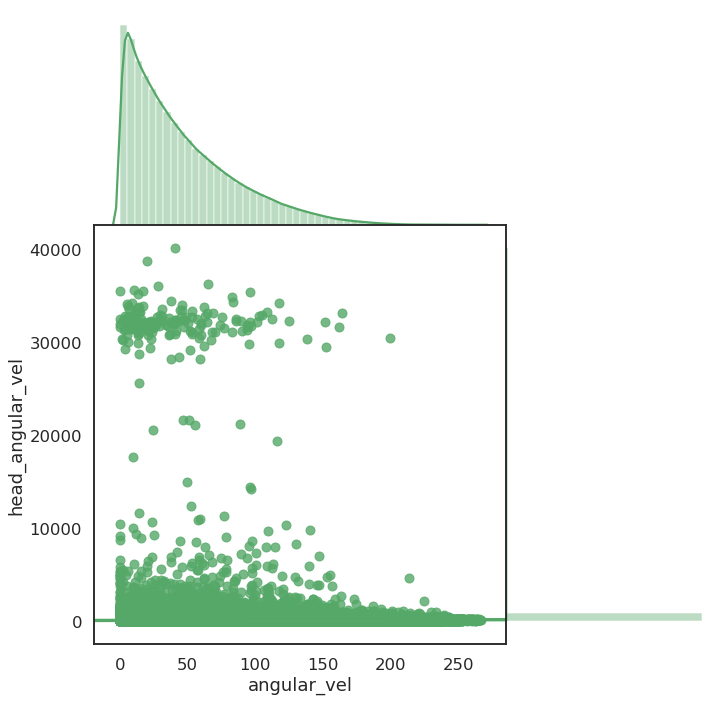

In [297]:
tmpdf = samples_df.query('isFixV==1')

g = sns.jointplot(x= tmpdf.combined_eye_vel_h,space=0,color='r', \
                  y=tmpdf.head_vel_h, kind="reg", height=10, ratio=2 )

plt.savefig(f'{PLOT_PATH}/cleaned_head_eye_h.png', transparent=True, bbox_inches='tight', quality=90)

g = sns.jointplot(x= tmpdf.combined_eye_vel_v,space=0,color='b', \
                  y=tmpdf.head_vel_v, kind="reg", height=10, ratio=2 )

plt.savefig(f'{PLOT_PATH}/cleaned_head_eye_v.png', transparent=True, bbox_inches='tight', quality=90)

g = sns.jointplot(x= tmpdf.angular_vel,space=0,color='g', \
                  y=tmpdf.head_angular_vel, kind="reg", height=10, ratio=2 )

plt.savefig(f'{PLOT_PATH}/cleaned_head_eye.png', transparent=True, bbox_inches='tight', quality=90)

In [348]:
(samples_df
 .query('head_angular_vel > 20000')
#  .groupby('subjectfileName')
#  .timestamp
 .count()
)

timestamp              214
leftEye_position_x     214
leftEye_position_y     214
leftEye_position_z     214
leftEye_direction_x    214
                      ... 
head_angular_vel       214
isFixV                 214
fix_duration           214
grasp_onset            214
grasp_duration         214
Length: 90, dtype: int64

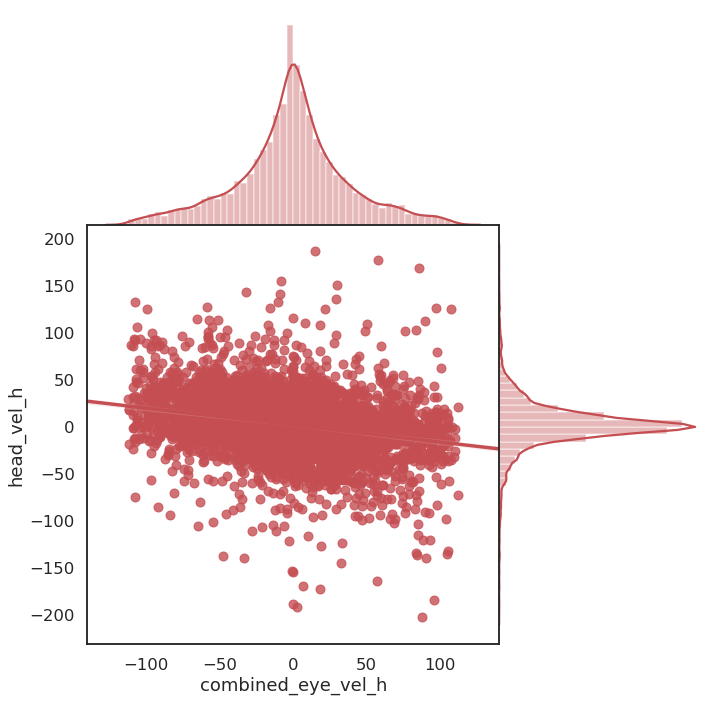

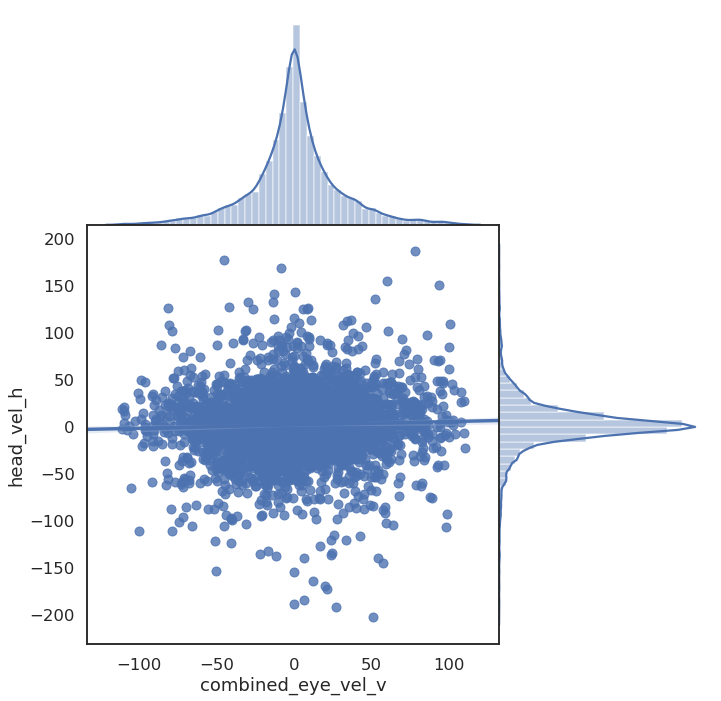

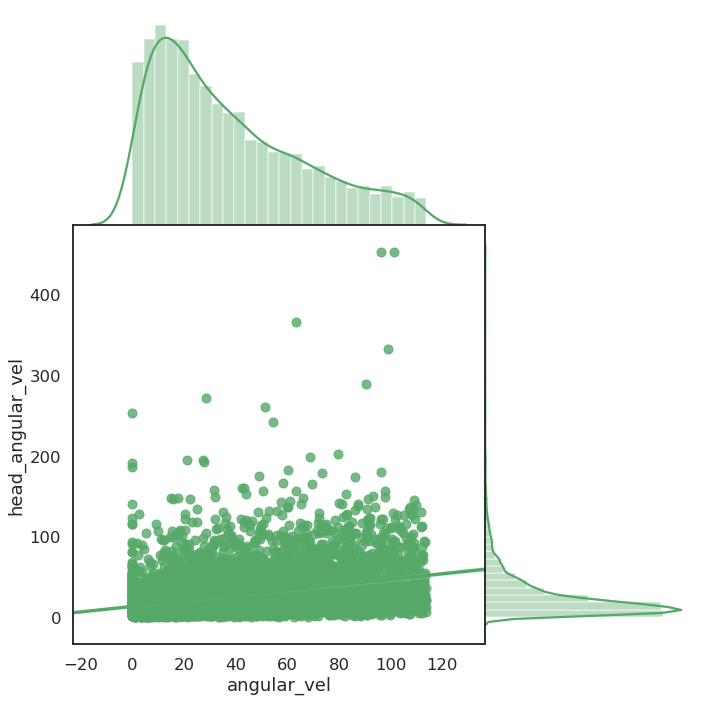

In [338]:
tmpdf = samples_df.query('isFixV == 1 and subjectID == 2018 and trialNum == 2')

g = sns.jointplot(x= tmpdf.combined_eye_vel_h,space=0,color='r', \
                  y=tmpdf.head_vel_h, kind="reg", height=10, ratio=2 )

plt.savefig(f'{PLOT_PATH}/cleaned_head_eye_h_subject2018.png', transparent=True, bbox_inches='tight', quality=90)

g = sns.jointplot(x= tmpdf.combined_eye_vel_v,space=0,color='b', \
                  y=tmpdf.head_vel_h, kind="reg", height=10, ratio=2 )

plt.savefig(f'{PLOT_PATH}/cleaned_head_eye_v_subject2018.png', transparent=True, bbox_inches='tight', quality=90)

g = sns.jointplot(x= tmpdf.angular_vel,space=0,color='g', \
                  y=tmpdf.head_angular_vel, kind="reg", height=10, ratio=2 )

plt.savefig(f'{PLOT_PATH}/cleaned_head_eye_subject2018.png', transparent=True, bbox_inches='tight', quality=90)

## Get fixations!

In [309]:
# samples_df.set_index('timestamp', inplace=True)
samples_df['fix_duration'] = (samples_df.groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False).isFixV
                              .apply(lambda x: x.groupby((x != x.shift()).cumsum())
                                     .transform(lambda x: (x.index[-1] - x.index[0]))
                                    )
                             ).reset_index().set_index('timestamp').isFixV

In [310]:
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/02_ET_samples_withFixDurations.csv', index=False)


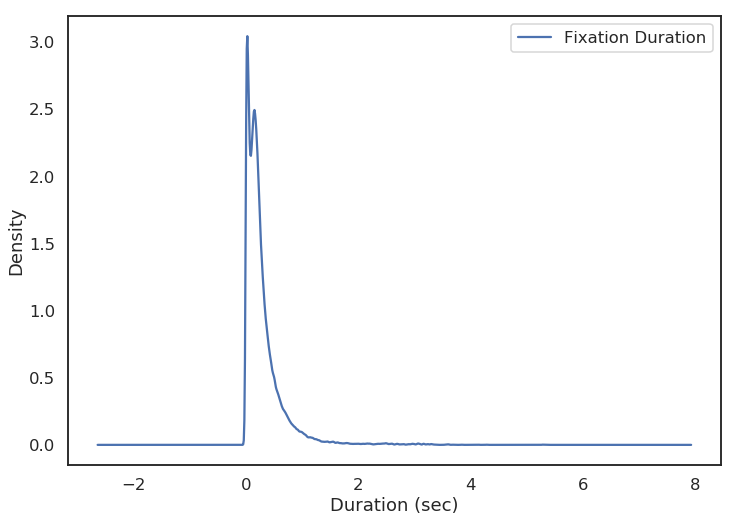

In [340]:
_, ax =plt.subplots()

(samples_df
 .query('isFixV==1')['fix_duration']
 .plot(kind='kde', ax=ax, color= 'b', label='Fixation Duration', legend=True)
)

ax.set_xlabel('Duration (sec)')
# (samples_df
#  .query('isFix==1 and isGoodFix==1')['fix_duration']
#  .plot(kind='kde', ax=ax, color= 'r')
# )

plt.savefig(f'{PLOT_PATH}/fix_duration.png', transparent=True, bbox_inches='tight', quality=90)

## Get Grasp Onset and Duration

In [313]:
samples_df.set_index('timestamp', inplace=True)
samples_df['grasp_onset'] = (samples_df.groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                             .handData_graspedObject
                             .apply(lambda x: x.groupby((x != x.shift()).cumsum())
                                     .transform(lambda x: x.index[0])
                                    )
                             ).reset_index().set_index('timestamp').handData_graspedObject

samples_df['grasp_duration'] = (samples_df.groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                             .handData_graspedObject
                             .apply(lambda x: x.groupby((x != x.shift()).cumsum())
                                     .transform(lambda x: (x.index[-1] - x.index[0]))
                                    )
                             ).reset_index().set_index('timestamp').handData_graspedObject

In [357]:
samples_df.trialID.fillna(0, inplace=True)
samples_df.to_csv(f'{PROCESSED_DATA_PATH}/03_ET_samples_withGraspOnset.csv', index=False)

In [325]:
samples_df.reset_index(inplace=True)

In [327]:
(samples_df.timestamp == samples_df.grasp_onset).sum()

7148551

In [ ]:
(samples_df
 .query('timestamp == grasp_onset and grasp_duration !=0 ')
#  .groupby('trialID')
 .grasp_onset
 .count()
)

In [329]:
samples_df.grasp_duration.describe()

count    1.059491e+07
mean     1.002766e+00
std      2.449785e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.421347e+00
max      3.262085e+01
Name: grasp_duration, dtype: float64

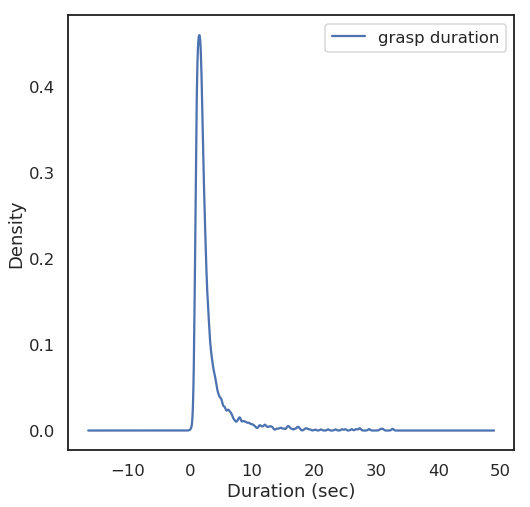

In [339]:
_, ax = plt.subplots(1,1, figsize=(8,8))
(samples_df
 .query('grasp_duration != 0')
 .grasp_duration
 .plot.kde(ax=ax, color='b', label='grasp duration', legend=True)
)
ax.set_xlabel('Duration (sec)')

plt.savefig(f'{PLOT_PATH}/grasp_duration.png', transparent=True, bbox_inches='tight', quality=90)

### Frame Rate across participants

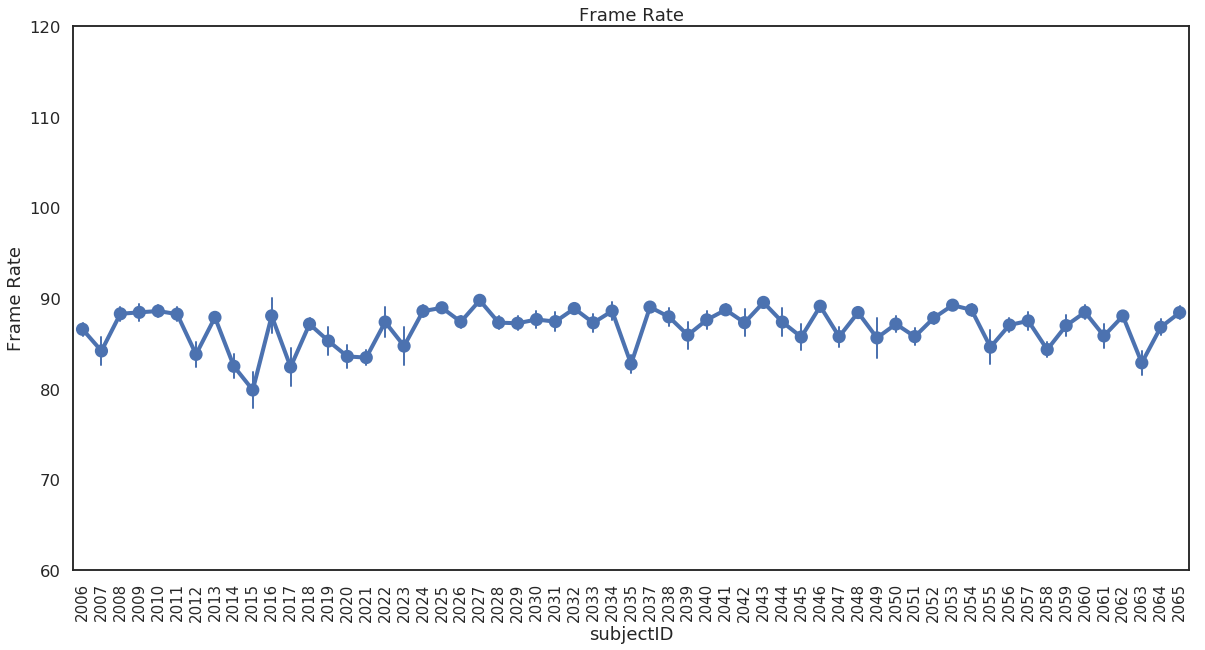

In [124]:
tmpdf = (
    samples_df
    .groupby(['subjectID','subjectfileName','trialNum'])['timestamp']
    .apply(lambda x: 1/np.mean(x - x.shift()))
    .rename('Frame Rate')
    .reset_index()
)
# display(tmpdf)

_, ax = plt.subplots(1,1,figsize=(20,10))
sns.pointplot(data=tmpdf, x='subjectID', y='Frame Rate', color='b',
              errwidth=2, capsize=0, saturation=0.5,ci='sd')
ax.set_ylim(60,120)
plt.xticks(rotation=90, fontsize=15)
plt.title('Frame Rate')
plt.savefig(PLOT_PATH+'/frame_rate.png', quality=90)

# SCRATCH!!!

[(-500, 500),
 Text(0, 0.5, 'Head Velocity'),
 (-500, 500),
 Text(0.5, 0, 'EIH Velocity'),
 Text(0.5, 1.0, 'Elevation')]

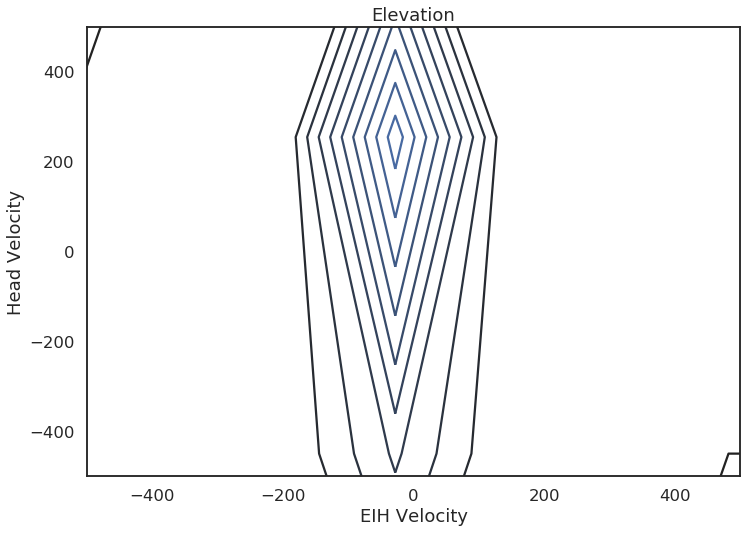

In [66]:
ax = sns.kdeplot(tmpdf.combined_eye_vel_v,tmpdf.head_vel_v, shade=False, c_map='Blues')
ax.set(title='Elevation', ylabel='Head Velocity', xlabel='EIH Velocity', xlim=(-500,500), ylim=(-500,500))

In [305]:
samples_df.timestamp

2            0.344199
3            0.352107
4            0.360528
5            0.370871
6            0.381480
              ...    
11020548    80.986656
11020549    80.997879
11020550    81.008926
11020551    81.020134
11020552    81.031464
Name: timestamp, Length: 10594907, dtype: float64

In [ ]:
tmpdf.head()

[(-100, 100),
 Text(0, 0.5, 'Head Velocity'),
 (-100, 100),
 Text(0.5, 0, 'EIH Velocity'),
 Text(0.5, 1.0, 'Azimuth')]

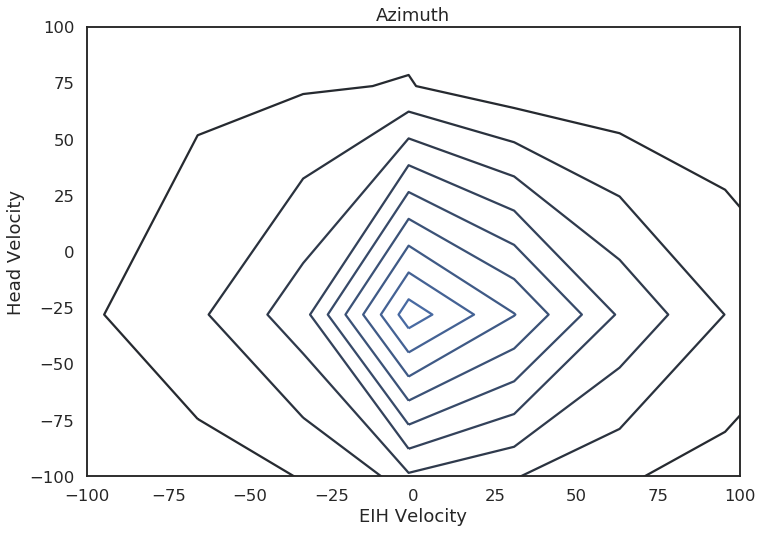

In [57]:
ax = sns.kdeplot(tmpdf.combined_eye_vel_h,tmpdf.head_vel_h, shade=False, c_map='Reds')
ax.set(title='Azimuth', ylabel='Head Velocity', xlabel='EIH Velocity', xlim=(-100,100), ylim=(-100,100))

[(0, 100),
 Text(0, 0.5, 'Head Velocity'),
 (0, 100),
 Text(0.5, 0, 'EIH Velocity'),
 Text(0.5, 1.0, 'Azimuth')]

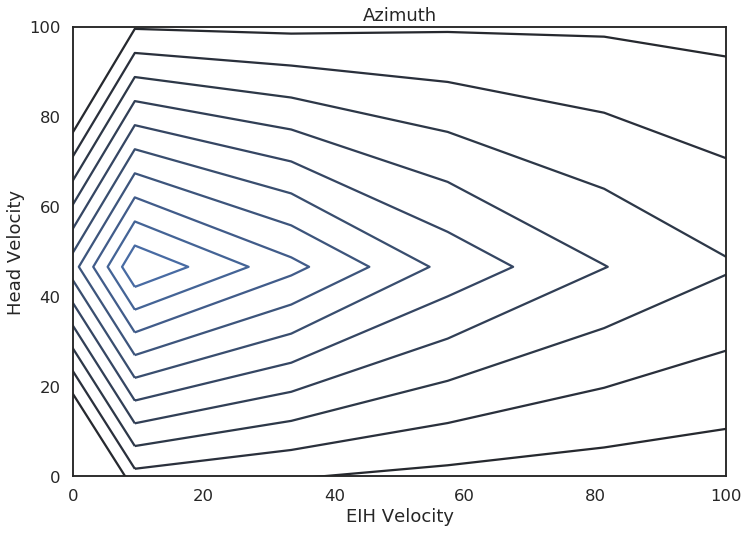

In [58]:
ax = sns.kdeplot(tmpdf.combined_eye_vel_h.abs(),tmpdf.head_vel_h.abs(), shade=False, c_map='Reds')
ax.set(title='Azimuth', ylabel='Head Velocity', xlabel='EIH Velocity', xlim=(0,100), ylim=(0,100))

[(0, 500),
 Text(0, 0.5, 'Head Velocity'),
 (0, 500),
 Text(0.5, 0, 'EIH Velocity'),
 Text(0.5, 1.0, 'Azimuth')]

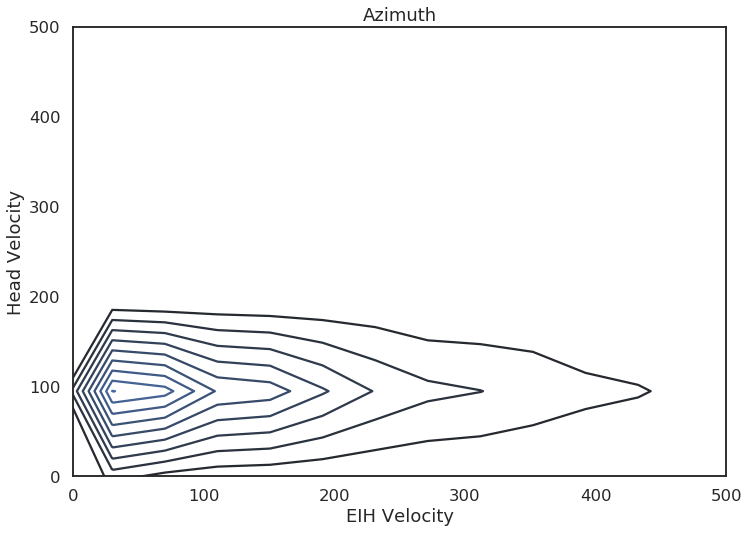

In [65]:
ax = sns.kdeplot(tmpdf.combined_eye_vel_h.abs(),tmpdf.head_vel_h.abs(), shade=False, c_map='Reds')
ax.set(title='Azimuth', ylabel='Head Velocity', xlabel='EIH Velocity', xlim=(0,500), ylim=(0,500))

In [47]:
samples_df['isFixLeftEye_h'] = (samples_df
                                .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                                .left_eye_acc_h
                                .transform(lambda x: mad_event(x)))
samples_df['isFixRightEye_h'] = (samples_df
                                 .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                                 .right_eye_acc_h
                                 .transform(lambda x: mad_event(x)))
samples_df['isFixLeftEye_v'] = (samples_df
                                .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                                .left_eye_acc_v
                                .transform(lambda x: mad_event(x)))
samples_df['isFixRightEye_v'] = (samples_df
                                 .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                                 .right_eye_acc_h
                                 .transform(lambda x: mad_event(x)))
samples_df['isFixCombinedEye_h'] = (samples_df
                                    .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                                    .combined_eye_acc_h
                                    .transform(lambda x: mad_event(x)))
samples_df['isFixCombinedEye_v'] = (samples_df
                                    .groupby(['subjectID', 'subjectfileName', 'trialNum'], as_index=False)
                                    .combined_eye_acc_v
                                    .transform(lambda x: mad_event(x)))


samples_df['isFixC'] = samples_df['isFixCombinedEye_h'] & samples_df['isFixCombinedEye_v']
samples_df['isFixR'] = samples_df['isFixLeftEye_h'] & samples_df['isFixLeftEye_v']
samples_df['isFixL'] = samples_df['isFixRightEye_h'] & samples_df['isFixRightEye_v']

c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
c:\users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


[(-100, 100),
 Text(0, 0.5, 'Head Velocity'),
 (-100, 100),
 Text(0.5, 0, 'EIH Velocity'),
 Text(0.5, 1.0, 'Elevation')]

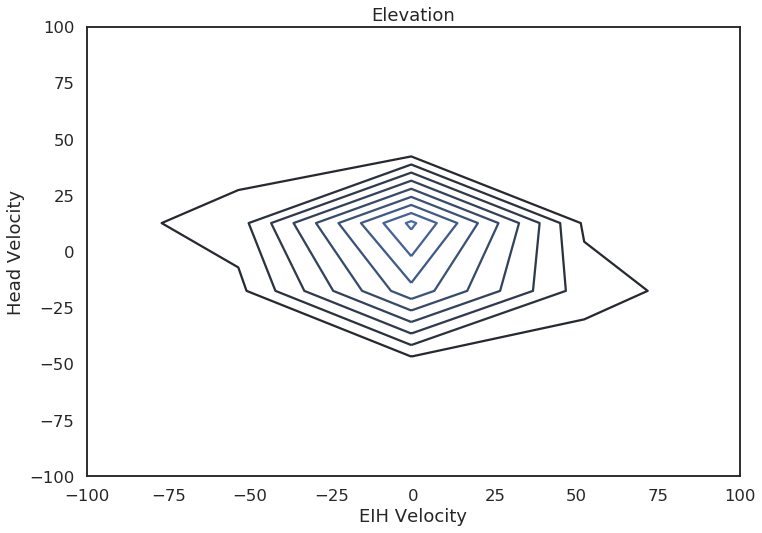

In [59]:
ax = sns.kdeplot(tmpdf.combined_eye_vel_v,tmpdf.head_vel_v, shade=False, c_map='Blues')
ax.set(title='Elevation', ylabel='Head Velocity', xlabel='EIH Velocity', xlim=(-100,100), ylim=(-100,100))

[(0, 100),
 Text(0, 0.5, 'Head Velocity'),
 (0, 100),
 Text(0.5, 0, 'EIH Velocity'),
 Text(0.5, 1.0, 'Elevation')]

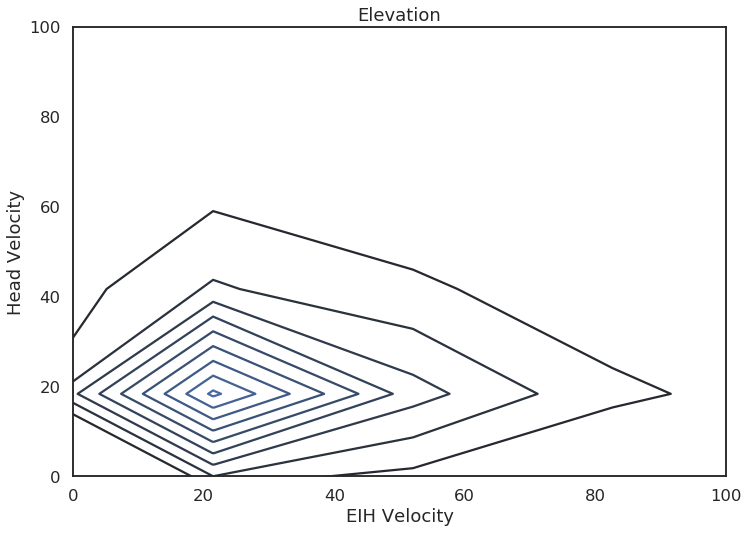

In [60]:
ax = sns.kdeplot(tmpdf.combined_eye_vel_v.abs(),tmpdf.head_vel_v.abs(), shade=False, c_map='Blues')
ax.set(title='Elevation', ylabel='Head Velocity', xlabel='EIH Velocity', xlim=(0,100), ylim=(0,100))